# E-commerce SQL + RFM + когортный анализ (датасет Olist)

## О проекте
Анализ e-commerce датасета Olist (Brazilian E-Commerce Public Dataset by Olist, Kaggle). Цель: понять, как устроена выручка по клиентским сегментам, и как когорты накапливают выручку и LTV во времени.

Два смысловых блока:
1) RFM-анализ (сегментация и концентрация выручки).  
2) Когортный анализ (удержание, выручка по месяцам с первой покупки, накопление и LTV).

---

## Данные

Используется публичный датасет:

Olist Brazilian E-Commerce Public Dataset  
Источник: Kaggle  
Описание: транзакционные данные маркетплейса Olist (Бразилия), включающие заказы, оплаты, клиентов и товары.

В проекте используются следующие таблицы:

---

### 1) orders
Содержит информацию о заказах.

Основные поля:
- order_id — уникальный идентификатор заказа  
- customer_id — идентификатор клиента  
- order_status — статус заказа  
- order_purchase_timestamp — дата и время покупки  
- order_approved_at — дата подтверждения оплаты  
- order_delivered_carrier_date — дата передачи в доставку  
- order_delivered_customer_date — дата доставки клиенту  
- order_estimated_delivery_date — плановая дата доставки  

Используется для:
- определения даты первой покупки (формирование когорт),
- расчёта Recency,
- построения временной структуры заказов.

---

### 2) order_payments
Содержит данные об оплатах заказов.

Основные поля:
- order_id — идентификатор заказа  
- payment_sequential — номер платежа (если их несколько)  
- payment_type — способ оплаты  
- payment_installments — количество платежей (рассрочка)  
- payment_value — сумма платежа  

Используется для:
- расчёта фактической выручки,
- агрегирования денежных показателей (Monetary),
- расчёта выручки по когортам,
- расчёта LTV.

---

### 3) customers
Содержит информацию о клиентах.

Основные поля:
- customer_id — технический идентификатор клиента (используется в заказах)  
- customer_unique_id — уникальный клиент (один человек может иметь несколько customer_id)  
- customer_zip_code_prefix — почтовый индекс  
- customer_city — город  
- customer_state — штат  

Используется для:
- расчёта числа уникальных клиентов,
- формирования RFM на уровне customer_unique_id,
- расчёта размера когорт (cohort_size).

---

### 4) order_items (используется частично)
Содержит информацию о товарах в заказах.

Основные поля:
- order_id — идентификатор заказа  
- order_item_id — номер позиции в заказе  
- product_id — идентификатор товара  
- seller_id — идентификатор продавца  
- price — цена товара  
- freight_value — стоимость доставки  

Используется для:
- проверки структуры заказа,
- дополнительных агрегатов при необходимости.

---

## Что сделано

### 1) Подготовка данных и базовые проверки
- Объединение таблиц через SQL и Pandas.
- Агрегация платежей до уровня заказа.
- Формирование клиентской таблицы.
- Проверка логики дат и сумм.

---

### 2) RFM-анализ

RFM = Recency / Frequency / Monetary

- Recency — давность последней покупки.
- Frequency — количество заказов.
- Monetary — суммарная выручка с клиента.

Что реализовано:
- Расчёт RFM-метрик на уровне клиента.
- Сегментация клиентов по скоринговой логике.
- Анализ распределения выручки по сегментам.
- Оценка концентрации выручки (кривая Паретто, кривая Лоренца коэффициент Джини).

Результат:
структура клиентской базы и выявление ключевых сегментов, формирующих основную выручку.

---

### 3) Когортный анализ

Когорта = месяц первой покупки клиента.  
Когортный индекс = месяц относительно первой покупки (M0, M1, M2…).

Реализовано:
- Расчёт размера когорт (cohort_size).
- Матрицы выручки по когортам.
- Отдельная визуализация M0 и накопления после M0.
- Расчёт накопительной выручки.
- Расчёт LTV по когортам:
  - M0 — средняя выручка на клиента в первый месяц,
  - накопление после M0 — вклад повторных покупок.

Результат:
видна динамика монетизации когорт и вклад повторных покупок в общий LTV.

---

## Итог

В результате получены две управленческие картины:

1) Клиентская структура (RFM + концентрация денег)  
   Понятно, какие сегменты формируют основную выручку и насколько она сконцентрирована.

2) Динамика по времени (когорты + выручка + LTV)  
   Видно, как когорты монетизируются, каков вклад первого месяца и насколько выражены повторные покупки.

Комплексный подход: сегментация клиентов + анализ поведения во времени.

In [97]:
!pip -q install kagglehub duckdb pandas

import os
import kagglehub

# качаем датасет
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print("Dataset path:", path)

# посмотрим файлы
files = sorted(os.listdir(path))
files

Using Colab cache for faster access to the 'brazilian-ecommerce' dataset.
Dataset path: /kaggle/input/brazilian-ecommerce


['olist_customers_dataset.csv',
 'olist_geolocation_dataset.csv',
 'olist_order_items_dataset.csv',
 'olist_order_payments_dataset.csv',
 'olist_order_reviews_dataset.csv',
 'olist_orders_dataset.csv',
 'olist_products_dataset.csv',
 'olist_sellers_dataset.csv',
 'product_category_name_translation.csv']

In [98]:
import duckdb

con = duckdb.connect(database=":memory:")
DATA_PATH = path

con.execute(f"""
CREATE TABLE orders AS
SELECT * FROM read_csv_auto('{DATA_PATH}/olist_orders_dataset.csv');

CREATE TABLE order_items AS
SELECT * FROM read_csv_auto('{DATA_PATH}/olist_order_items_dataset.csv');

CREATE TABLE payments AS
SELECT * FROM read_csv_auto('{DATA_PATH}/olist_order_payments_dataset.csv');

CREATE TABLE customers AS
SELECT * FROM read_csv_auto('{DATA_PATH}/olist_customers_dataset.csv');
""")

print("Tables created:", con.execute("SHOW TABLES").fetchall())

Tables created: [('customers',), ('order_items',), ('orders',), ('payments',)]


In [99]:
con.execute("""
SELECT 'orders' AS table_name, COUNT(*) AS rows FROM orders
UNION ALL
SELECT 'order_items', COUNT(*) FROM order_items
UNION ALL
SELECT 'payments', COUNT(*) FROM payments
UNION ALL
SELECT 'customers', COUNT(*) FROM customers
""").fetchdf()

,table_name,rows
0,orders,99441
1,order_items,112650
2,payments,103886
3,customers,99441


In [100]:
con.execute("DESCRIBE orders").fetchdf()

,column_name,column_type,null,key,default,extra
0,order_id,VARCHAR,YES,None,None,None
1,customer_id,VARCHAR,YES,None,None,None
2,order_status,VARCHAR,YES,None,None,None
3,order_purchase_timestamp,TIMESTAMP,YES,None,None,None
4,order_approved_at,TIMESTAMP,YES,None,None,None
5,order_delivered_carrier_date,TIMESTAMP,YES,None,None,None
6,order_delivered_customer_date,TIMESTAMP,YES,None,None,None
7,order_estimated_delivery_date,TIMESTAMP,YES,None,None,None


In [101]:
con.execute("DESCRIBE order_items").fetchdf()

,column_name,column_type,null,key,default,extra
0,order_id,VARCHAR,YES,None,None,None
1,order_item_id,BIGINT,YES,None,None,None
2,product_id,VARCHAR,YES,None,None,None
3,seller_id,VARCHAR,YES,None,None,None
4,shipping_limit_date,TIMESTAMP,YES,None,None,None
5,price,DOUBLE,YES,None,None,None
6,freight_value,DOUBLE,YES,None,None,None


In [102]:
con.execute("DESCRIBE payments").fetchdf()

,column_name,column_type,null,key,default,extra
0,order_id,VARCHAR,YES,None,None,None
1,payment_sequential,BIGINT,YES,None,None,None
2,payment_type,VARCHAR,YES,None,None,None
3,payment_installments,BIGINT,YES,None,None,None
4,payment_value,DOUBLE,YES,None,None,None


In [103]:
con.execute("DESCRIBE customers").fetchdf()

,column_name,column_type,null,key,default,extra
0,customer_id,VARCHAR,YES,None,None,None
1,customer_unique_id,VARCHAR,YES,None,None,None
2,customer_zip_code_prefix,VARCHAR,YES,None,None,None
3,customer_city,VARCHAR,YES,None,None,None
4,customer_state,VARCHAR,YES,None,None,None


In [104]:
con.execute("SELECT * FROM orders LIMIT 5").fetchdf()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [105]:
con.execute("SELECT * FROM order_items LIMIT 5").fetchdf()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [106]:
con.execute("SELECT * FROM payments LIMIT 5").fetchdf()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [107]:
con.execute("SELECT * FROM customers LIMIT 5").fetchdf()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,09790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,01151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,08775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


CSV-файлы датасета Olist были загружены в in-memory базу DuckDB и зарегистрированы как SQL-таблицы. Это позволяет выполнять полноценные SQL-запросы (JOIN, агрегаты, оконные функции) напрямую поверх исходных данных без предварительной загрузки в Pandas.
База данных корректно содержит заказы за полный период наблюдений.

## Проверка структуры данных перед JOIN

Перед тем как объединять таблицы с помощью JOIN и строить RFM-анализ,
необходимо понять структуру данных и связи между таблицами.

В частности, важно ответить на следующие вопросы:
- по каким ключам таблицы можно безопасно объединять;
- где возможны дубли строк при объединении;
- на каком уровне следует считать клиентов (заказ, технический ID или реальный пользователь).

Для этого ниже выполняются диагностические запросы, которые считают:
- общее количество строк в таблицах;
- количество уникальных идентификаторов (order_id, customer_id, customer_unique_id).

Цель проверок: понять кардинальность связей между таблицами (один-к-одному, один-ко-многим) и избежать логических ошибок при JOIN.

In [108]:
con.execute("""
SELECT
  COUNT(*) AS orders_rows,
  COUNT(DISTINCT order_id) AS orders_distinct_order_id,
  COUNT(DISTINCT customer_id) AS orders_distinct_customer_id
FROM orders
""").fetchdf()

,orders_rows,orders_distinct_order_id,orders_distinct_customer_id
0,99441,99441,99441


In [109]:
con.execute("""
SELECT
  COUNT(*) AS items_rows,
  COUNT(DISTINCT order_id) AS items_distinct_order_id
FROM order_items
""").fetchdf()

,items_rows,items_distinct_order_id
0,112650,98666


In [110]:
con.execute("""
SELECT
  COUNT(*) AS payments_rows,
  COUNT(DISTINCT order_id) AS payments_distinct_order_id
FROM payments
""").fetchdf()

,payments_rows,payments_distinct_order_id
0,103886,99440


In [111]:
con.execute("""
SELECT
  COUNT(*) AS customers_rows,
  COUNT(DISTINCT customer_id) AS customers_distinct_customer_id,
  COUNT(DISTINCT customer_unique_id) AS customers_distinct_unique_id
FROM customers
""").fetchdf()

,customers_rows,customers_distinct_customer_id,customers_distinct_unique_id
0,99441,99441,96096


На предыдущем шаге мы обнаружили потенциальную аномалию: число уникальных customer_id в таблице orders оказалось равным числу заказов.
Это может означать:
- каждый клиент совершил ровно один заказ (что маловероятно для e-commerce)
- мы неверно интерпретируем уровень агрегации данных
- используем технический идентификатор клиента, который не отражает реального пользователя.

Чтобы понять природу этого эффекта и корректно выбрать уровень анализа для RFM, выполняются следующие проверки.

Проверка: действительно ли order_id уникален и как соотносятся заказы и клиенты

In [112]:
con.execute("""
SELECT
  COUNT(*) AS orders_rows,
  COUNT(DISTINCT order_id) AS distinct_orders,
  COUNT(DISTINCT customer_id) AS
distinct_customers
FROM orders
""").fetchdf()

,orders_rows,distinct_orders,distinct_customers
0,99441,99441,99441


Проверка: существуют ли клиенты с более чем одним заказом

In [113]:
con.execute("""
SELECT customer_id, COUNT(*) AS orders_cnt
FROM orders
GROUP BY customer_id
HAVING COUNT(*) > 1
ORDER BY orders_cnt DESC
LIMIT 10
""").fetchdf()

,customer_id,orders_cnt


Эти проверки позволяют корректно определить:
- на каком уровне следует считать клиентов (заказ / customer_id / customer_unique_id);
- где возможна потеря или искажение данных при JOIN;
- какой идентификатор использовать для RFM-анализа, чтобы не занижать частоту покупок и не искажать сегментацию.

**ВЫВОД**

customer_id в датасете Olist:
- не отражает поведение реального клиента;
- используется на уровне заказа;
- не подходит для расчёта RFM.

Для анализа клиентского поведения необходимо использовать: customer_unique_id из таблицы customers, который агрегирует несколько заказов одного и того же пользователя.

Проверка соответствия технического идентификатора заказа (customer_id) и реального пользователя (customer_unique_id). На предыдущем шаге было выявлено, что в таблице orders каждый customer_id встречается ровно один раз, что нетипично для e-commerce. Это означает, что customer_id является техническим идентификатором покупки, а не реального клиента. Для корректного RFM-анализа необходимо определить:
- могут ли разные customer_id соответствовать одному реальному пользователю;
- какой идентификатор следует использовать для агрегации клиентского поведения.

В датасете Olist реальный пользователь представлен полем customer_unique_id в таблице customers. Следующий шаг проверяет связь между customer_id и customer_unique_id.

In [114]:
con.execute("""
SELECT
    customer_unique_id,
    COUNT(DISTINCT customer_id) AS customer_ids_cnt
FROM customers
GROUP BY customer_unique_id
HAVING COUNT(DISTINCT customer_id) > 1
ORDER BY customer_ids_cnt DESC
LIMIT 10
""").fetchdf()

,customer_unique_id,customer_ids_cnt
0,8d50f5eadf50201ccdcedfb9e2ac8455,17
1,3e43e6105506432c953e165fb2acf44c,9
2,6469f99c1f9dfae7733b25662e7f1782,7
3,ca77025e7201e3b30c44b472ff346268,7
4,1b6c7548a2a1f9037c1fd3ddfed95f33,7
5,dc813062e0fc23409cd255f7f53c7074,6
6,de34b16117594161a6a89c50b289d35a,6
7,f0e310a6839dce9de1638e0fe5ab282a,6
8,63cfc61cee11cbe306bff5857d00bfe4,6
9,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


**ПРОВЕРКА 2: АГРЕГИРОВАННАЯ КАРТИНА**

In [115]:
con.execute("""
SELECT
    COUNT(*) AS customers_rows,
    COUNT(DISTINCT customer_id) AS distinct_customer_id,
    COUNT(DISTINCT customer_unique_id) AS distinct_customer_unique_id
FROM customers
""").fetchdf()

,customers_rows,distinct_customer_id,distinct_customer_unique_id
0,99441,99441,96096


Результаты запросов показывают, что один customer_unique_id может соответствовать нескольким customer_id.

Например, отдельные пользователи имеют до 17 различных customer_id, что означает совершение нескольких заказов.

Это подтверждает, что:
- customer_id является техническим идентификатором заказа;
- customer_unique_id представляет реального пользователя.

Следовательно, все клиентские метрики (Recency, Frequency, Monetary) должны агрегироваться на уровне customer_unique_id, а не customer_id, чтобы корректно отражать поведение клиентов.

Использование customer_id для RFM-анализа привело бы к занижению частоты покупок и искажению клиентской сегментации.

**Подготовка RFM-датасета**

На данном этапе формируется базовая RFM-таблица:
- агрегированный датасет, в котором каждая строка соответствует одному реальному клиенту (customer_unique_id).

Для этого:
- заказы (orders) объединяются с платежами (payments) по order_id;
- добавляется информация о реальном клиенте через таблицу customers;
- данные агрегируются по customer_unique_id.

Цель: получить таблицу вида\
customer_unique_id\
Recency — разница между последней датой покупки клиента и максимальной датой в датасете\
Frequency — COUNT(DISTINCT order_id)\
Monetary — SUM(payment_value)

**Шаг 1: определяем дату анализа**\
Нужна точка отсчёта: последняя дата в данных (reference date для recency)

In [116]:
con.execute("""
SELECT
    MAX(order_purchase_timestamp) AS snapshot_date
FROM orders
WHERE order_status = 'delivered'
""").fetchdf()

,snapshot_date
0,2018-08-29 15:00:37


**Шаг 2: считаем R, F, M (основной запрос)**

In [117]:
con.execute("""
CREATE OR REPLACE TABLE rfm_base AS
WITH orders_payments AS (
    SELECT
        o.order_id,
        o.customer_id,
        o.order_purchase_timestamp,
        p.payment_value
    FROM orders o
    JOIN payments p
        ON o.order_id = p.order_id
    WHERE o.order_status = 'delivered'
),

orders_customers AS (
    SELECT
        c.customer_unique_id,
        op.order_id,
        op.order_purchase_timestamp,
        op.payment_value
    FROM orders_payments op
    JOIN customers c
        ON op.customer_id = c.customer_id
)

SELECT
    customer_unique_id,
    MAX(order_purchase_timestamp) AS last_purchase_date,
    COUNT(DISTINCT order_id) AS frequency,
    SUM(payment_value) AS monetary
FROM orders_customers
GROUP BY customer_unique_id
""")

con.execute("""
SELECT *
FROM rfm_base
""").fetchdf()

,customer_unique_id,last_purchase_date,frequency,monetary
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,1,146.87
1,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,1,173.30
2,addec96d2e059c80c30fe6871d30d177,2018-02-19 14:38:35,1,22.77
3,1175e95fb47ddff9de6b2b06188f7e0d,2018-01-18 12:35:45,2,83.19
4,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-27 17:23:20,1,40.40
...,...,...,...,...
93352,82d46759af0369aad49084bacf85a6c3,2017-11-14 12:04:09,1,199.92
93353,d111b06b6f3a2add0d2241325f65b5ca,2018-03-06 09:16:56,1,108.59
93354,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,1,88.78
93355,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,1,129.06


**Промежуточный вывод по RFM-базе**\
На текущем этапе сформирована агрегированная таблица rfm_base, содержащая по одной строке на каждого реального клиента (customer_unique_id).

В таблице представлены:
- last_purchase_date — дата последней покупки клиента
- frequency — количество уникальных заказов
- monetary — суммарная выручка от клиента

Общее количество строк — 93 357, что соответствует числу уникальных реальных пользователей.

По таблице видно:\
большинство клиентов имеют frequency = 1 (разовые покупки);
часть клиентов совершали 2 и более заказов;
распределение monetary варьируется от небольших чеков до более крупных сумм.

Таким образом, база корректно агрегирована на уровне реального пользователя и готова к расчёту финальных RFM-метрик.

Следующий щаг: расчет recency

In [118]:
con.execute("""

CREATE OR REPLACE TABLE rfm_enriched AS

WITH snapshot AS (
    SELECT MAX(order_purchase_timestamp) AS snapshot_date
    FROM orders
    WHERE order_status = 'delivered'
)

SELECT
    r.*,
    DATE_DIFF('day', r.last_purchase_date, s.snapshot_date) AS recency
FROM rfm_base r
CROSS JOIN snapshot s
""")

In [119]:
con.execute("""

SELECT
  re.*,
FROM rfm_enriched re
""").fetchdf()

,customer_unique_id,last_purchase_date,frequency,monetary,recency
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,1,146.87,470
1,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,1,173.30,169
2,addec96d2e059c80c30fe6871d30d177,2018-02-19 14:38:35,1,22.77,191
3,1175e95fb47ddff9de6b2b06188f7e0d,2018-01-18 12:35:45,2,83.19,223
4,2a7745e1ed516b289ed9b29c7d0539a5,2017-11-27 17:23:20,1,40.40,275
...,...,...,...,...,...
93352,82d46759af0369aad49084bacf85a6c3,2017-11-14 12:04:09,1,199.92,288
93353,d111b06b6f3a2add0d2241325f65b5ca,2018-03-06 09:16:56,1,108.59,176
93354,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,1,88.78,144
93355,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,1,129.06,147


Поделим всех клиентов на 5 равных групп

1 — худшая группа\
5 — лучшая группа

Теперь у каждого клиента будет:

R score (1–5)\
F score (1–5)\
M score (1–5)

In [120]:
con.execute("""
CREATE OR REPLACE TABLE rfm_scored AS

SELECT
    customer_unique_id,
    recency,
    frequency,
    monetary,

    NTILE(5) OVER (ORDER BY recency DESC)   AS r_score,
    NTILE(5) OVER (ORDER BY frequency ASC) AS f_score,
    NTILE(5) OVER (ORDER BY monetary ASC)  AS m_score

FROM rfm_enriched
""")

In [121]:
con.execute("""
SELECT *
FROM rfm_scored
""").fetchdf()

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score
0,317cfc692e3f86c45c95697c61c853a6,4,1,9.59,5,5,1
1,bd06ce0e06ad77a7f681f1a4960a3cc6,350,1,10.07,2,2,1
2,b33336f46234b24a613ad9064d13106d,69,1,10.89,5,5,1
3,6f5b9d1cdccc4d28f0483a612edecacf,361,1,11.63,2,2,1
4,2878e5b88167faab17d4fb83a986d38b,304,1,11.63,2,2,1
...,...,...,...,...,...,...,...
93352,459bef486812aa25204be022145caa62,35,1,6922.21,5,5,5
93353,dc4802a71eae9be1dd28f5d788ceb526,563,1,6929.31,1,1,5
93354,763c8b1c9c68a0229c42c9fc6f662b93,45,1,7274.88,5,5,5
93355,da122df9eeddfedc1dc1f5349a1a690c,515,2,7571.63,1,5,5


In [122]:
con.execute("""
SELECT
  frequency,
  COUNT(*) AS customers_cnt
FROM rfm_enriched
GROUP BY frequency
ORDER BY frequency
""").fetchdf()

,frequency,customers_cnt
0,1,90556
1,2,2573
2,3,181
3,4,28
4,5,9
5,6,5
6,7,3
7,9,1
8,15,1


In [123]:
con.execute("""
SELECT
  f_score,
  COUNT(*) AS customers_cnt,
  MIN(frequency) AS min_f,
  MAX(frequency) AS max_f
FROM rfm_scored
GROUP BY f_score
ORDER BY f_score
""").fetchdf()

,f_score,customers_cnt,min_f,max_f
0,1,18672,1,1
1,2,18672,1,1
2,3,18671,1,1
3,4,18671,1,1
4,5,18671,1,15


Анализ распределения frequency показал, что 97% клиентов совершили только одну покупку. В связи с этим квантильная сегментация по F не даёт бизнес-информативного разделения. Основную вариативность RFM-сегментации обеспечивают Recency и Monetary.

Для адекватной сегментации по frequency нужно сделать её вручную с помощью CASE.

In [124]:
con.execute("""
CREATE OR REPLACE TABLE rfm_scored AS

SELECT
    customer_unique_id,
    recency,
    frequency,
    monetary,

    -- R (меньше дней = лучше)
    NTILE(5) OVER (ORDER BY recency DESC) AS r_score,

    -- F (ручная логика)
    CASE
        WHEN frequency = 1 THEN 1
        WHEN frequency = 2 THEN 2
        WHEN frequency = 3 THEN 3
        WHEN frequency = 4 THEN 4
        ELSE 5
    END AS f_score,

    -- M (больше денег = лучше)
    NTILE(5) OVER (ORDER BY monetary ASC) AS m_score

FROM rfm_enriched
""")

In [125]:
con.execute("""
SELECT *
FROM rfm_scored
""").fetchdf()

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score
0,317cfc692e3f86c45c95697c61c853a6,4,1,9.59,5,1,1
1,bd06ce0e06ad77a7f681f1a4960a3cc6,350,1,10.07,2,1,1
2,b33336f46234b24a613ad9064d13106d,69,1,10.89,5,1,1
3,6f5b9d1cdccc4d28f0483a612edecacf,361,1,11.63,2,1,1
4,2878e5b88167faab17d4fb83a986d38b,304,1,11.63,2,1,1
...,...,...,...,...,...,...,...
93352,459bef486812aa25204be022145caa62,35,1,6922.21,5,1,5
93353,dc4802a71eae9be1dd28f5d788ceb526,563,1,6929.31,1,1,5
93354,763c8b1c9c68a0229c42c9fc6f662b93,45,1,7274.88,5,1,5
93355,da122df9eeddfedc1dc1f5349a1a690c,515,2,7571.63,1,2,5


Сегментация по RFM коду

In [126]:
con.execute("""
CREATE OR REPLACE TABLE rfm_final AS

SELECT
    *,
    CAST(r_score AS VARCHAR) ||
    CAST(f_score AS VARCHAR) ||
    CAST(m_score AS VARCHAR) AS rfm_score
FROM rfm_scored
""")

Сегментация по названию

In [127]:
con.execute("""
CREATE OR REPLACE TABLE rfm_segmented AS

SELECT
    *,
    CASE

        WHEN r_score >= 4 AND f_score >= 4 AND m_score >= 4
            THEN 'Champions'

        WHEN r_score >= 3 AND f_score >= 3
            THEN 'Loyal Customers'

        WHEN r_score <= 2 AND f_score >= 3
            THEN 'At Risk'

        WHEN r_score <= 2 AND f_score = 1
            THEN 'Hibernating'

        ELSE 'Potential'

    END AS segment

FROM rfm_final
""")

Сводка по сегментам

In [128]:
con.execute("""
SELECT
    segment,
    COUNT(*) AS customers_cnt,
    ROUND(AVG(monetary),2) AS avg_spend,
    ROUND(AVG(frequency),2) AS avg_frequency,
    ROUND(AVG(recency),2) AS avg_recency
FROM rfm_segmented
GROUP BY segment
ORDER BY customers_cnt DESC
""").fetchdf()

,segment,customers_cnt,avg_spend,avg_frequency,avg_recency
0,Potential,56782,165.96,1.05,137.13
1,Hibernating,36347,161.87,1.00,394.46
2,Loyal Customers,125,460.08,3.14,125.94
3,At Risk,71,423.69,3.14,389.07
4,Champions,32,873.64,4.97,82.56


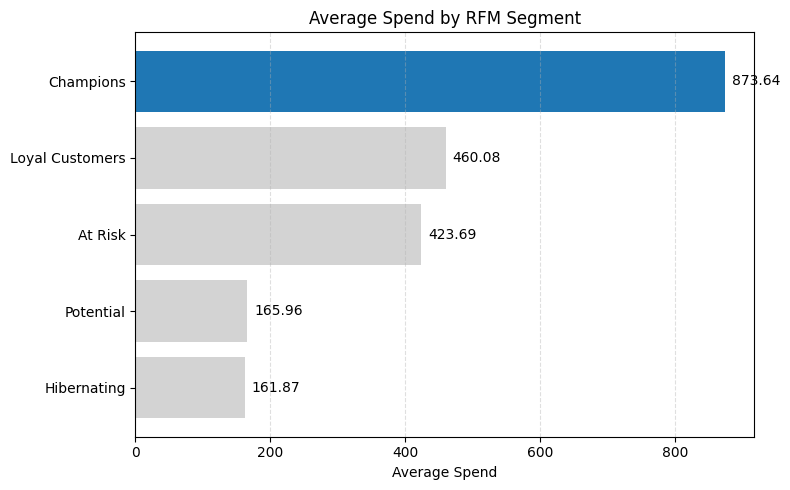

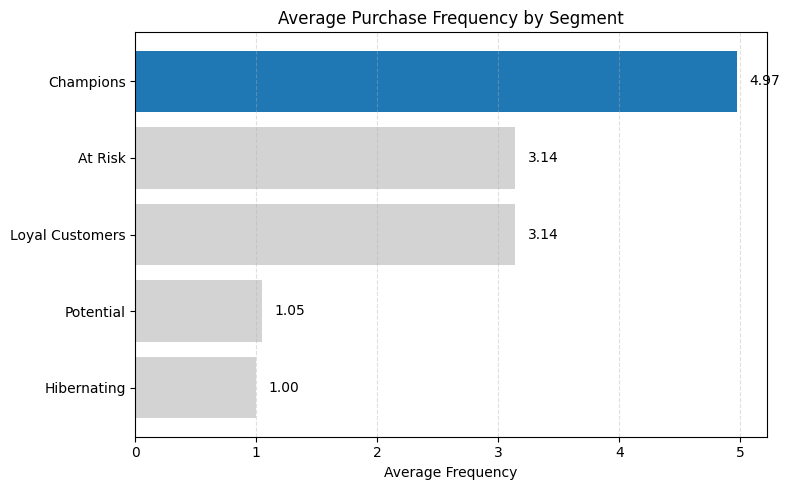

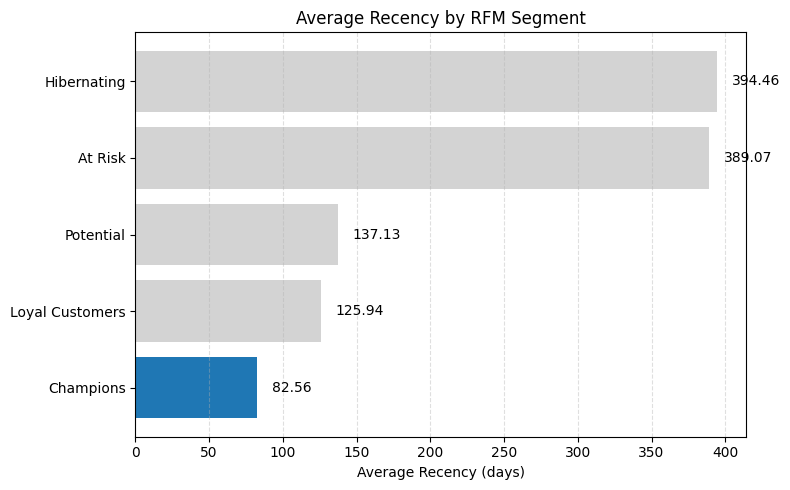

In [129]:
df_metrics = con.execute("""
SELECT
    segment,
    COUNT(*) AS customers_cnt,
    ROUND(AVG(monetary),2) AS avg_spend,
    ROUND(AVG(frequency),2) AS avg_frequency,
    ROUND(AVG(recency),2) AS avg_recency
FROM rfm_segmented
GROUP BY segment
ORDER BY customers_cnt DESC
""").fetchdf()

import matplotlib.pyplot as plt

df_plot = df_metrics.sort_values("avg_spend", ascending=True)

colors = ["#d3d3d3" if seg != "Champions" else "#1f77b4"
          for seg in df_plot["segment"]]

plt.figure(figsize=(8,5))

plt.barh(
    df_plot["segment"],
    df_plot["avg_spend"],
    color=colors
)

for i, value in enumerate(df_plot["avg_spend"]):
    plt.text(value + 10, i, f"{value:.2f}", va='center')

plt.xlabel("Average Spend")
plt.title("Average Spend by RFM Segment")

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

df_plot = df_metrics.sort_values("avg_frequency", ascending=True)

colors = ["#d3d3d3" if seg != "Champions" else "#1f77b4"
          for seg in df_plot["segment"]]

plt.figure(figsize=(8,5))

plt.barh(
    df_plot["segment"],
    df_plot["avg_frequency"],
    color=colors
)

for i, value in enumerate(df_plot["avg_frequency"]):
    plt.text(value + 0.1, i, f"{value:.2f}", va='center')

plt.xlabel("Average Frequency")
plt.title("Average Purchase Frequency by Segment")

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

df_plot = df_metrics.sort_values("avg_recency", ascending=True)

colors = ["#d3d3d3" if seg != "Champions" else "#1f77b4"
          for seg in df_plot["segment"]]

plt.figure(figsize=(8,5))

plt.barh(
    df_plot["segment"],
    df_plot["avg_recency"],
    color=colors
)

for i, value in enumerate(df_plot["avg_recency"]):
    plt.text(value + 10, i, f"{value:.2f}", va='center')

plt.xlabel("Average Recency (days)")
plt.title("Average Recency by RFM Segment")

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

**ПРОМЕЖУТОЧНЫЙ ВЫВОД**

**1️. Основная масса клиентов (ядро по объему выручки)**

Potential 56782\
Hibernating 36347\
Это 93% всей базы.

Большинство клиентов покупали 1 раз\
Средний чек 160

У Hibernating огромный recency (394 дня), они фактически ушли.

**2️. Loyal Customers маленький слой лояльных**

125 клиентов\
Средний чек 460\
Частота 3.14\
Recency 125 дней

**3️. At Risk опасная зона**

71 клиент\
Средний чек 423\
Частота 3.14\
Recency 389 дней\
Бывшие хорошие клиенты\
Срочно надо возвращать, иначе это потерянная прибыль.

**4️. Champions (ядро по качеству клиентов)**

32 клиента\
Средний чек 873\
Частота 4.97\
Recency 82 дня\

**5. Вывод**

Большая часть клиентов одноразовые.\
Слабое удержание.\
Нет эффективной системы возврата.

**Далее: доля выручки по сегментам**

Задача:\
Посчитать общий оборот\
Посчитать оборот по сегментам\
Посчитать % долю

In [130]:
con.execute("""
WITH segment_revenue AS (
    SELECT
        segment,
        COUNT(*) AS customers_cnt,
        SUM(monetary) AS total_revenue
    FROM rfm_segmented
    GROUP BY segment
),

total AS (
    SELECT SUM(monetary) AS grand_total
    FROM rfm_segmented
)

SELECT
    s.segment,
    s.customers_cnt,
    ROUND(s.total_revenue,2) AS total_revenue,
    ROUND(s.total_revenue / t.grand_total * 100,2) AS revenue_share_pct
FROM segment_revenue s
CROSS JOIN total t
ORDER BY total_revenue DESC
""").fetchdf()

,segment,customers_cnt,total_revenue,revenue_share_pct
0,Potential,56782,9423290.25,61.10
1,Hibernating,36347,5883622.69,38.15
2,Loyal Customers,125,57510.37,0.37
3,At Risk,71,30081.99,0.20
4,Champions,32,27956.47,0.18


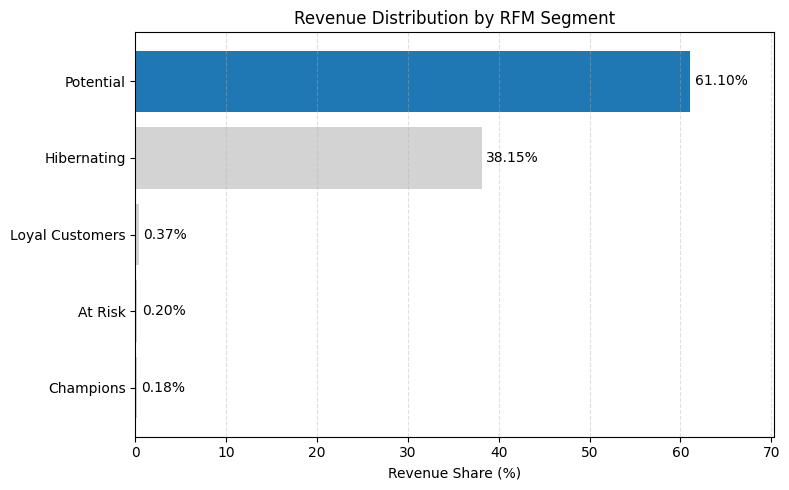

In [131]:
df = con.execute("""
WITH segment_revenue AS (
    SELECT
        segment,
        COUNT(*) AS customers_cnt,
        SUM(monetary) AS total_revenue
    FROM rfm_segmented
    GROUP BY segment
),

total AS (
    SELECT SUM(monetary) AS grand_total
    FROM rfm_segmented
)

SELECT
    s.segment,
    s.customers_cnt,
    ROUND(s.total_revenue,2) AS total_revenue,
    ROUND(s.total_revenue / t.grand_total * 100,2) AS revenue_share_pct
FROM segment_revenue s
CROSS JOIN total t
ORDER BY total_revenue DESC
""").fetchdf()

import matplotlib.pyplot as plt
import numpy as np

# сортируем по доле выручки (если вдруг не отсортировано)
df_plot = df.sort_values("revenue_share_pct", ascending=True)

colors = ["#d3d3d3" if seg != "Potential" else "#1f77b4"
          for seg in df_plot["segment"]]

plt.figure(figsize=(8,5))

bars = plt.barh(
    df_plot["segment"],
    df_plot["revenue_share_pct"],
    color=colors
)

for i, value in enumerate(df_plot["revenue_share_pct"]):
    plt.text(value + 0.5, i, f"{value:.2f}%", va='center')

plt.xlabel("Revenue Share (%)")
plt.title("Revenue Distribution by RFM Segment")

plt.xlim(0, max(df_plot["revenue_share_pct"]) * 1.15)
plt.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Интерпретация результатов RFM-анализа

### Текущая картина

Проведённый RFM-анализ выявил: модель является acquisition-driven, а не retention-driven.

Бизнес функционирует преимущественно за счёт:
- постоянного притока новых клиентов,
- одноразовых покупок,
- высокого объёма трафика.

Эта модель роста отличается от той, где выручка формируется за счёт повторных покупок и удержания.

---

## Структура выручки

### 1 Основной оборот формирует сегмент Potential (61%)

Сегмент Potential состоит преимущественно из клиентов с одной покупкой. Несмотря на низкую частоту и умеренный средний чек, массовость этого сегмента обеспечивает основную долю выручки.

Это означает, что масштабирование бизнеса происходит за счёт объёма входящего трафика, а не повторных продаж.

---

### 2 Retention практически отсутствует

Сегменты Champions и Loyal Customers формируют менее 1% общей выручки.

Это указывает на:
- отсутствие развитой системы повторных продаж,
- отсутствие программы лояльности,
- отсутствие системной CRM-реактивации.

База клиентов большая, но уровень удержания низкий.

---

### 3 Стратегическая уязвимость

При снижении потока новых клиентов выручка может существенно сократиться, поскольку повторные покупки не являются драйвером бизнеса.

Компания зависит от acquisition-стратегии и чувствительна к изменениям в стоимости трафика.

---

## Почему сегмент Champions всё равно важен

Сегмент Champions не является ядром выручки, однако он представляет стратегическую ценность:

- демонстрирует потенциал высокого LTV,
- подтверждает способность продукта удерживать клиентов,
- формирует модель идеального клиента.

Однако текущий масштаб этого сегмента минимален.

---

## Ключевой вывод

RFM-анализ показал, что бизнес практически полностью зависит от одноразовых покупок.

> Несмотря на высокий LTV сегмента Champions, основная выручка формируется массовым сегментом одноразовых покупателей (Potential). Это указывает на слабый уровень удержания клиентов и зависимость бизнеса от постоянного притока нового трафика.

**Далее смотрим: какой процент выручки дают 20 процентов топ-клиентов**

In [132]:
con.execute("""
WITH ranked_customers AS (
    SELECT
        customer_unique_id,
        monetary,
        SUM(monetary) OVER () AS total_revenue,
        SUM(monetary) OVER (
            ORDER BY monetary DESC
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS cumulative_revenue,
        ROW_NUMBER() OVER (ORDER BY monetary DESC) AS row_num,
        COUNT(*) OVER () AS total_customers
    FROM rfm_segmented
)

SELECT
    customer_unique_id,
    monetary,
    ROUND(cumulative_revenue / total_revenue * 100, 4) AS cumulative_revenue_pct,
    ROUND(row_num * 100.0 / total_customers, 4) AS customers_pct
FROM ranked_customers
ORDER BY monetary DESC
""").fetchdf()

,customer_unique_id,monetary,cumulative_revenue_pct,customers_pct
0,0a0a92112bd4c708ca5fde585afaa872,13664.08,0.0886,0.0011
1,da122df9eeddfedc1dc1f5349a1a690c,7571.63,0.1377,0.0021
2,763c8b1c9c68a0229c42c9fc6f662b93,7274.88,0.1849,0.0032
3,dc4802a71eae9be1dd28f5d788ceb526,6929.31,0.2298,0.0043
4,459bef486812aa25204be022145caa62,6922.21,0.2747,0.0054
...,...,...,...,...
93352,6f5b9d1cdccc4d28f0483a612edecacf,11.63,99.9997,99.9957
93353,2878e5b88167faab17d4fb83a986d38b,11.63,99.9998,99.9968
93354,b33336f46234b24a613ad9064d13106d,10.89,99.9999,99.9979
93355,bd06ce0e06ad77a7f681f1a4960a3cc6,10.07,99.9999,99.9989


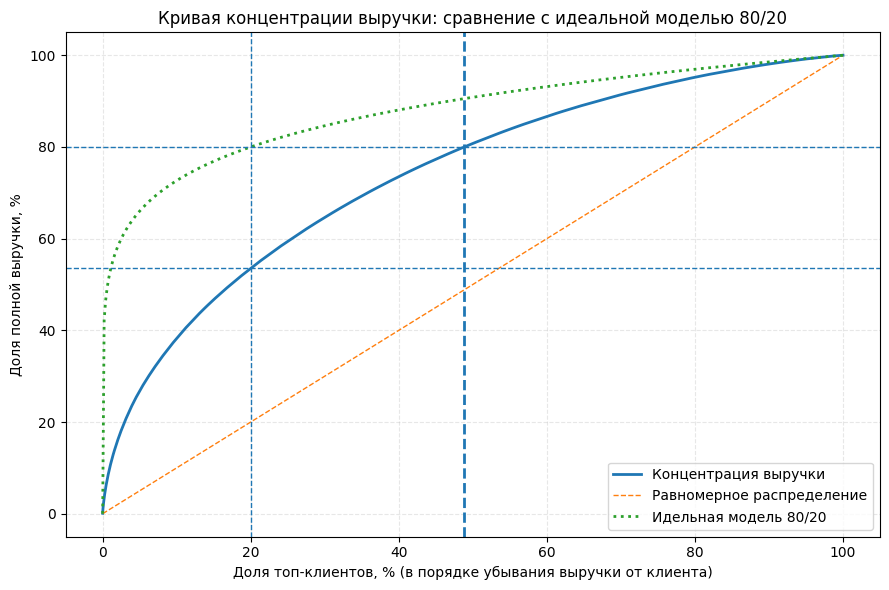

20% топ-клиентов дают долю полной выручки 53.52%
80% полной выручки приходит от 48.85% топ-клиентов
Идеальная модель: 80% полной выручки приходит от 20% топ-клиентов


In [133]:
pareto_df = con.execute("""
WITH ranked_customers AS (
    SELECT
        customer_unique_id,
        monetary,
        SUM(monetary) OVER () AS total_revenue,
        SUM(monetary) OVER (
            ORDER BY monetary DESC
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS cumulative_revenue,
        ROW_NUMBER() OVER (ORDER BY monetary DESC) AS row_num,
        COUNT(*) OVER () AS total_customers
    FROM rfm_segmented
)

SELECT
    customer_unique_id,
    monetary,
    ROUND(cumulative_revenue / total_revenue * 100, 4) AS cumulative_revenue_pct,
    ROUND(row_num * 100.0 / total_customers, 4) AS customers_pct
FROM ranked_customers
ORDER BY monetary DESC
""").fetchdf()

import matplotlib.pyplot as plt
import numpy as np

# x = % клиентов, y = cumulative % выручки
x = pareto_df["customers_pct"].values
y = pareto_df["cumulative_revenue_pct"].values

# --- 1) Выручка от топ-20% клиентов (по фактической кривой)
idx_20 = np.argmin(np.abs(x - 20))
rev_at_20 = y[idx_20]

# --- 2) % клиентов для достижения 80% выручки (по фактической кривой)
threshold = 80
idx_80 = np.argmax(y >= threshold)
customers_at_80 = x[idx_80]

# --- Гладкая "идеальная" 80/20 кривая: y = 100*(x/100)^a, и y(20)=80
a = np.log(0.8) / np.log(0.2)

x_smooth = np.linspace(0, 100, 500)
y_ideal_smooth = 100 * (x_smooth / 100) ** a

plt.figure(figsize=(9, 6))

# Реальная кривая Парето
plt.plot(x, y, linewidth=2, label="Концентрация выручки")

# Диагональ (равномерно)
plt.plot([0, 100], [0, 100], linestyle="--", linewidth=1, label="Равномерное распределение")

# Идеальная ГЛАДКАЯ 80/20
plt.plot(
    x_smooth, y_ideal_smooth,
    linestyle=":", linewidth=2,
    label="Идельная модель 80/20"
)

# Вертикальная линия 20% клиентов
plt.axvline(20, linestyle="--", linewidth=1)

# Горизонтальная линия фактической выручки от 20% клиентов
plt.axhline(rev_at_20, linestyle="--", linewidth=1)

# Горизонтальная линия 80% выручки
plt.axhline(80, linestyle="--", linewidth=1)

# Вертикальная линия X% клиентов, дающих 80% (факт)
plt.axvline(customers_at_80, linestyle="--", linewidth=2)

plt.xlabel("Доля топ-клиентов, % (в порядке убывания выручки от клиента)")
plt.ylabel("Доля полной выручки, %")
plt.title("Кривая концентрации выручки: сравнение с идеальной моделью 80/20")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

print(f"20% топ-клиентов дают долю полной выручки {rev_at_20:.2f}%")
print(f"80% полной выручки приходит от {customers_at_80:.2f}% топ-клиентов")
print("Идеальная модель: 80% полной выручки приходит от 20% топ-клиентов")

## Вывод по концентрации выручки

### Фактическая картина

- 20% клиентов формируют ≈ 53% выручки  
- Для достижения 80% выручки требуется ≈ 49% клиентской базы  

Это означает умеренную концентрацию оборота. Выручка распределена значительно равномернее, чем в идеальной модели 80/20.

### Что это значит

1. Отсутствует выраженное VIP-ядро.
   Топ-клиенты не формируют доминирующую долю оборота.

2. Бизнес не опирается на узкий слой лояльных клиентов.  
   Чтобы собрать основную часть выручки, необходимо задействовать почти половину базы.

3. Модель acquisition-driven, не retention-driven.
   Выручка поддерживается массовым притоком клиентов, не высоким LTV.

### Потенциальные риски

- Снижение рекламного трафика приведёт к прямому падению выручки.
- Низкая концентрация оборота говорит о слабых повторных продажах.
- Отсутствие сильного слоя высокоценностных клиентов ограничивает рост маржи.

### Что можно улучшить

1. Усилить работу с сегментами Champions и Loyal:
   - персональные предложения
   - программы лояльности
   - приоритетный сервис

2. Реактивация сегмента At Risk:
   - таргетированные кампании возврата
   - персональные скидки
   - напоминания

3. Повышение частоты покупок у массового сегмента Potential:
   - кросс-сейл
   - рекомендательные механики
   - триггерные коммуникации

### Вывод

Концентрация выручки умеренная: 20% клиентов формируют 53% оборота.  
Бизнес зависит от широкой клиентской базы и не обладает выраженным ядром высокоценностных клиентов.  

Основной вектор роста: развитие retention-механик и увеличение доли выручки, формируемой верхними RFM-сегментами.

**Далее делаем второй аспект аналитики распределения выручки: кривую Лоренца**

In [134]:
lorenz_df = con.execute("""
WITH ranked AS (
    SELECT
        customer_unique_id,
        monetary,
        SUM(monetary) OVER () AS total_revenue,
        COUNT(*) OVER () AS total_customers,
        SUM(monetary) OVER (
            ORDER BY monetary ASC
            ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
        ) AS cumulative_revenue,
        ROW_NUMBER() OVER (ORDER BY monetary ASC) AS row_num
    FROM rfm_segmented
)

SELECT
    ROUND(row_num * 100.0 / total_customers, 4) AS customers_pct,
    ROUND(cumulative_revenue * 100.0 / total_revenue, 4) AS revenue_pct
FROM ranked
ORDER BY monetary ASC
""").fetchdf()

lorenz_df.head()

,customers_pct,revenue_pct
0,0.0011,0.0001
1,0.0021,0.0001
2,0.0032,0.0002
3,0.0043,0.0003
4,0.0054,0.0003


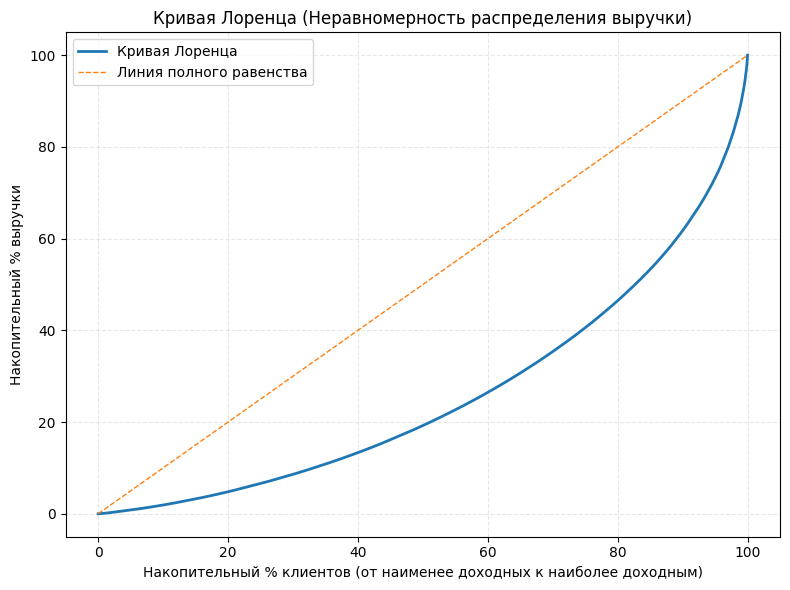

Коэффициент Джини: 0.4786


In [135]:
import matplotlib.pyplot as plt
import numpy as np

x = lorenz_df["customers_pct"]
y = lorenz_df["revenue_pct"]

plt.figure(figsize=(8,6))

# Кривая Лоренца
plt.plot(x, y, linewidth=2, label="Кривая Лоренца")

# Линия полного равенства
plt.plot([0,100],[0,100], linestyle="--", linewidth=1, label="Линия полного равенства")

plt.xlabel("Накопительный % клиентов (от наименее доходных к наиболее доходным)")
plt.ylabel("Накопительный % выручки")
plt.title("Кривая Лоренца (Неравномерность распределения выручки)")

plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

# переводим проценты в доли (0-1)
x_vals = x / 100
y_vals = y / 100

# считаем площадь под кривой методом трапеций
area_under_curve = np.trapezoid(y_vals, x_vals)

gini = 1 - 2 * area_under_curve

print(f"Коэффициент Джини: {round(gini,4)}")

## Выводы по кривой Лоренца и коэффициенту Джини

Построенная кривая Лоренца демонстрирует умеренную концентрацию выручки среди клиентов. Коэффициент Джини составил:

Gini = 0.47

### Что это означает для данного датасета

Выручка распределена неравномерно, но без экстремального перекоса.  
Бизнес не зависит критически от узкого круга VIP-клиентов.  
При этом существует выраженная разница между низкодоходными и высокодоходными покупателями.

Это согласуется с результатами Pareto-анализа:

- 20% клиентов формируют ~53% выручки  
- Для достижения 80% оборота требуется почти 49% базы  

Таким образом, модель является:

- не равномерной mass-моделью  
- но и не высоко-концентрированной retention-моделью  
- а промежуточной  

---

### Интерпретация

Gini ≈ 0.47 указывает на то, что:

- У бизнеса есть слой более ценных клиентов  
- Однако отсутствует ярко выраженное ядро, формирующее основную маржу  
- Доход распределён относительно широко по клиентской базе  

Это означает:

- Бизнес устойчив к потере отдельных клиентов  
- Но имеет ограниченный потенциал LTV и VIP-монетизации  
- Рост возможен за счёт усиления концентрации выручки в верхнем сегменте  

---

### Ключевой вывод

Структура выручки умеренно концентрирована. Бизнес не опирается на узкий сегмент, не демонстрирует выраженного retention-ядра. Модель ближе к acquisition-driven с потенциалом развития более прибыльного клиентского слоя.

**CHURN RATE**

E-commerce без подписки.\
Можем определить churn так:\
Клиент считается отвалившимся, если он не совершал покупок в последние N дней.\
Возьмём, например, 180 дней.

In [136]:
metrics_df = con.execute("""
WITH base AS (
    SELECT
        customer_unique_id,
        recency,
        frequency,
        CASE WHEN recency > 180 THEN 1 ELSE 0 END AS is_churned,
        CASE WHEN frequency > 1 THEN 1 ELSE 0 END AS is_repeat
    FROM rfm_segmented
),

agg AS (
    SELECT
        COUNT(*) AS total_customers,
        SUM(is_churned) AS churned_customers,
        SUM(is_repeat) AS repeat_customers,
        SUM(CASE WHEN is_churned = 0 THEN 1 ELSE 0 END) AS active_customers,
        SUM(CASE WHEN is_churned = 0 AND is_repeat = 1 THEN 1 ELSE 0 END) AS repeat_active_customers
    FROM base
)

SELECT
    'Churn Rate (recency > 180 days)' AS metric,
    total_customers,
    churned_customers AS customers_with_metric,
    ROUND(churned_customers * 100.0 / total_customers, 2) AS value_pct
FROM agg

UNION ALL

SELECT
    'Repeat Purchase Rate (frequency > 1)' AS metric,
    total_customers,
    repeat_customers AS customers_with_metric,
    ROUND(repeat_customers * 100.0 / total_customers, 2) AS value_pct
FROM agg

UNION ALL

SELECT
    'Repeat Rate among Active Customers (recency ≤ 180)' AS metric,
    active_customers AS total_customers,
    repeat_active_customers AS customers_with_metric,
    ROUND(repeat_active_customers * 100.0 / active_customers, 2) AS value_pct
FROM agg
""").fetchdf()

metrics_df

,metric,total_customers,customers_with_metric,value_pct
0,Churn Rate (recency > 180 days),93357.0,55131.0,59.05
1,Repeat Purchase Rate (frequency > 1),93357.0,2801.0,3.00
2,Repeat Rate among Active Customers (recency ≤ ...,38226.0,1237.0,3.24


## Комплексная интерпретация

Все полученные метрики складываются в единую картину:

- Умеренная концентрация выручки (Gini = 0.47)
- 20% клиентов формируют только ≈ 53% оборота
- Для достижения 80% выручки требуется почти 49% базы
- Повторные покупки составляют ≈ 3%
- Churn rate 59%

Это указывает на acquisition-driven модель:

- Бизнес живёт за счёт постоянного притока новых клиентов  
- LTV низкий
- Повторная монетизация практически отсутствует  
- Слабое удержание

---

### Вывод

Проблема не только в оттоке клиентов. Проблема в том, что клиенты изначально не становятся повторными.

Бизнес масштабируется за счёт объёма трафика, а не за счёт развития клиентской базы.

Это делает модель:

- сильно зависимой от маркетингового бюджета
- чувствительной к росту CAC
- ограниченной в LTV  

Потенциал роста: усиление концентрации выручки, развитие повторной монетизации.

## Когортный анализ

> Что происходит с клиентами после их первой покупки?

Мы смотрим не средние значения по всей базе,  
а поведение групп клиентов, пришедших в разное время.

Например:

- Клиенты, впервые купившие в январе  
- Что с ними в феврале?  
- В марте?  
- Через 6 месяцев?  

И так для каждой когорты.

---

## Почему это важно в данном проекте

Мы уже выяснили:

- Churn ≈ 59%
- Repeat purchase ≈ 3%
- Модель *acquisition-driven*
- Gini = 0.47
- 20% клиентов дают 53% выручки

Всё это агрегированные метрики.  
Это статическая фотография бизнеса.

Когортный анализ позволит понять:

- Клиенты "умирают" сразу или постепенно?
- Живут ли они 2–3 месяца?
- Есть ли разница между когортами?
- Улучшается ли поведение клиентов со временем?

Это динамика, а не усреднённый показатель.

**Шаг 1. Определяем когорту клиента**

Нужно:
Для каждого клиента определить:
месяц первой покупки

Для каждой покупки определить:
разницу в месяцах от первой покупки

Cohort base

In [137]:
con.execute("""
WITH first_purchase AS (
    SELECT
        c.customer_unique_id,
        MIN(o.order_purchase_timestamp) AS first_purchase_date
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
),

orders_enriched AS (
    SELECT
        c.customer_unique_id,
        DATE_TRUNC('month', o.order_purchase_timestamp) AS order_month,
        DATE_TRUNC('month', fp.first_purchase_date) AS cohort_month,
        DATE_DIFF('month',
                  DATE_TRUNC('month', fp.first_purchase_date),
                  DATE_TRUNC('month', o.order_purchase_timestamp)
        ) AS cohort_index
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    JOIN first_purchase fp
        ON c.customer_unique_id = fp.customer_unique_id
    WHERE o.order_status = 'delivered'
)

SELECT *
FROM orders_enriched
ORDER BY customer_unique_id, order_month
""").fetchdf()

,customer_unique_id,order_month,cohort_month,cohort_index
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-05-01,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,2018-05-01,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,2017-10-01,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,2017-11-01,0
...,...,...,...,...
96473,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-01,2017-06-01,0
96474,fffea47cd6d3cc0a88bd621562a9d061,2017-12-01,2017-12-01,0
96475,ffff371b4d645b6ecea244b27531430a,2017-02-01,2017-02-01,0
96476,ffff5962728ec6157033ef9805bacc48,2018-05-01,2018-05-01,0


**Шаг 2. Строим retention matrix**

In [138]:
con.execute("""

CREATE OR REPLACE TABLE orders_enriched AS

WITH first_purchase AS (
    SELECT
        c.customer_unique_id,
        MIN(o.order_purchase_timestamp) AS first_purchase_date
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
)

    SELECT
        c.customer_unique_id,
        DATE_TRUNC('month', o.order_purchase_timestamp) AS order_month,
        DATE_TRUNC('month', fp.first_purchase_date) AS cohort_month,
        DATE_DIFF('month',
                  DATE_TRUNC('month', fp.first_purchase_date),
                  DATE_TRUNC('month', o.order_purchase_timestamp)
        ) AS cohort_index
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    JOIN first_purchase fp
        ON c.customer_unique_id = fp.customer_unique_id
    WHERE o.order_status = 'delivered'
""")

In [139]:
retention_df = con.execute("""
WITH cohort_size AS (
    SELECT
        cohort_month,
        COUNT(DISTINCT customer_unique_id) AS cohort_size
    FROM orders_enriched
    WHERE cohort_index = 0
    GROUP BY cohort_month
),

cohort_activity AS (
    SELECT
        cohort_month,
        cohort_index,
        COUNT(DISTINCT customer_unique_id) AS active_customers
    FROM orders_enriched
    GROUP BY cohort_month, cohort_index
)

SELECT
    a.cohort_month,
    a.cohort_index,
    a.active_customers,
    s.cohort_size,
    ROUND(a.active_customers * 100.0 / s.cohort_size, 2) AS retention_pct
FROM cohort_activity a
JOIN cohort_size s
    ON a.cohort_month = s.cohort_month
ORDER BY a.cohort_month, a.cohort_index;
""").fetchdf()

retention_pivot = retention_df.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="retention_pct"
)

In [140]:
import numpy as np
import pandas as pd

# 1) Pivot
retention_pivot = retention_df.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="retention_pct"
)

# 2) max_date из БД
max_date = con.execute("""
    SELECT MAX(order_month)
    FROM orders_enriched
""").fetchone()[0]
max_date = pd.to_datetime(max_date)

def max_possible_index(cohort_month: pd.Timestamp) -> int:
    cohort_month = pd.to_datetime(cohort_month)
    return (max_date.year - cohort_month.year) * 12 + (max_date.month - cohort_month.month)

# 3) Расширяем колонки до реального максимума
max_ci = int(max_possible_index(retention_pivot.index.min()))
retention_pivot = retention_pivot.reindex(columns=range(max_ci + 1))

# 4) Внутри доступного прошлого: NaN -> 0 (это "не вернулись")
retention_filled = retention_pivot.fillna(0)

# 5) Будущее режем обратно в NaN
retention_fixed = retention_filled.copy()
for cohort_month in retention_fixed.index:
    max_idx = max_possible_index(cohort_month)
    retention_fixed.loc[cohort_month, max_idx+1:] = np.nan

# 6) Добавляем отсутствующие когорты (месяцы) как строки полностью NaN
full_cohort_months = pd.date_range(
    start=retention_fixed.index.min(),
    end=retention_fixed.index.max(),
    freq="MS"
)
retention_fixed = retention_fixed.reindex(full_cohort_months)

# 7) Гарантия: строки, которых не было (cohort_size=0) => полностью NaN
missing_rows = retention_fixed.index.difference(retention_filled.index)
retention_fixed.loc[missing_rows] = np.nan

# --- 8) помечаем data gap month как NaN в матрице удержания
gap_month = pd.Timestamp("2016-11-01")  # month-start

# order_month для каждой ячейки = cohort_month + cohort_index месяцев
cohort_months = retention_fixed.index.to_series()
for ci in retention_fixed.columns:
    order_month_for_cell = cohort_months + pd.DateOffset(months=int(ci))
    mask_gap = (order_month_for_cell.values == gap_month.to_datetime64())
    # ставим NaN только там, где этот месяц действительно участвует
    retention_fixed.loc[mask_gap, ci] = np.nan

retention_fixed

cohort_index,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2016-09-01,100.0,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0
2016-10-01,100.0,NaN,0.00,0.00,0.00,0.00,0.38,0.00,0.00,0.38,...,0.00,0.38,0.00,0.38,0.0,0.76,0.76,0.0,0.0,NaN
2016-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01,100.0,100.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,NaN,NaN,NaN
2017-01-01,100.0,0.28,0.28,0.14,0.42,0.14,0.42,0.14,0.14,0.00,...,0.14,0.14,0.28,0.42,0.0,0.14,NaN,NaN,NaN,NaN
2017-02-01,100.0,0.18,0.31,0.12,0.43,0.12,0.25,0.18,0.12,0.18,...,0.12,0.06,0.06,0.18,0.0,NaN,NaN,NaN,NaN,NaN
2017-03-01,100.0,0.44,0.36,0.40,0.36,0.16,0.16,0.32,0.32,0.08,...,0.16,0.24,0.08,0.12,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-01,100.0,0.62,0.22,0.18,0.27,0.27,0.35,0.31,0.31,0.18,...,0.09,0.09,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-05-01,100.0,0.46,0.46,0.29,0.29,0.32,0.41,0.14,0.26,0.26,...,0.17,0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,100.0,0.49,0.40,0.43,0.30,0.40,0.36,0.23,0.13,0.20,...,0.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Выводы по матрице удержания

Матрица удержания построена с учетом:
- заполнения внутренних пропусков нулями (0 = клиенты не вернулись),
- сохранения NaN справа от диагонали (будущие периоды, недоступные в датасете),
- добавления отсутствующих месяцев когорт как строк (полностью NaN).

В матрице отсутствует когорта 2016-11:
- в ноябре 2016 нет клиентов, для которых этот месяц стал первой delivered-покупкой,
- строка 2016-11 добавлена вручную и полностью состоит из NaN.

По данным retention-матрицы видно, что в ноябре 2016:
- удержание для когорты 2016-09 (индекс 2) равно 0,
- удержание для когорты 2016-10 (индекс 1) равно 0,
- новая когорта отсутствует.

Это означает, что:
- нет повторных покупок сентябрьской когорты,
- нет повторных покупок октябрьской когорты,
- нет первых покупок в ноябре 2016.

На уровне retention-анализа это выглядит как полное отсутствие delivered-активности в ноябре 2016.

---

## Следующие шаги

Для подтверждения и интерпретации аномалии необходимо:

1. Проверить общее количество заказов в ноябре 2016 (без фильтра по статусу).
2. Проанализировать распределение заказов по статусам в ноябре.
3. Проверить наличие возможной «дыры» в данных (пропуск выгрузки).
4. Построить динамику заказов по месяцам для выявления структурного разрыва.

Цель следующего этапа — определить, является ли отсутствие активности:
- реальным бизнес-фактом,
- следствием фильтрации по статусу delivered,
- либо артефактом данных.

In [141]:
con.execute("""
SELECT
  COUNT(*) AS delivered_orders_nov_2016
FROM orders
WHERE order_status = 'delivered'
  AND DATE_TRUNC('month', order_purchase_timestamp) = '2016-11-01'
""").fetchdf()

,delivered_orders_nov_2016
0,0


**Подтверждение нулевой delivered-активности в ноябре 2016 года**

In [142]:
# 0) Базовая фиксация месяца
target_month = "2016-11-01"

# 1) Сколько ВСЕХ заказов было в ноябре 2016 (без фильтра по статусу)
total_orders_nov = con.execute(f"""
SELECT COUNT(*) AS total_orders_nov_2016
FROM orders
WHERE DATE_TRUNC('month', order_purchase_timestamp) = '{target_month}'
""").fetchdf()
total_orders_nov

,total_orders_nov_2016
0,0


**В ноябре вообще не было заказов**

In [143]:
con.execute("""
SELECT
  DATE_TRUNC('month', order_purchase_timestamp) AS month,
  COUNT(*) AS total_orders
FROM orders
WHERE order_purchase_timestamp BETWEEN '2016-10-01' AND '2016-12-31'
GROUP BY 1
ORDER BY 1
""").fetchdf()

,month,total_orders
0,2016-10-01,324
1,2016-12-01,1


## Влияние ноября 2016 на когортный анализ и денежные метрики

Проверки показали:

- Октябрь 2016: 324 заказа  
- Ноябрь 2016: 0 заказов  
- Декабрь 2016: 1 заказ  

Таким образом, в ноябре 2016 года в датасете полностью отсутствуют заказы (data gap). В декабре 2016 наблюдается аномально низкая активность (1 заказ).

---

### 1) Как это влияет на матрицу удержания

Ноябрь 2016 попадает в жизненный цикл двух когорт:

- Когорта 2016-09: cohort_index = 2
- Когорта 2016-10: cohort_index = 1

Важно: нули в этих ячейках нельзя интерпретировать как "никто не вернулся", потому что это не поведенческий сигнал, а отсутствие данных.

Поэтому в матрице удержания значения для месяца 2016-11 принудительно помечены как NaN.

Ноябрь не влияет на:
- более поздние когорты,
- будущие месяцы жизненного цикла,
- расчёт удержания/выручки для других периодов.

---

### 2) Влияние декабря 2016

В декабре когорта размером 1 клиент (тоже артефакт данных)

Это приводит к эффекту:
- cohort_index = 1: удержание 100% (единственный клиент декабря купил снова в январе)

---

## Влияние на денежные метрики (Cohort Revenue, Cumulative Cohort Revenue, LTV)

Data gap ноября 2016:

- не ломает формулы расчёта,
- корректно отражается как NaN в соответствующих ячейках,
- не влияет на LTV других когорт.

LTV рассчитывается как:

LTV = cumulative_revenue / cohort_size

Для отсутствующей когорты 2016-11 значения неприменимы (NaN), что математически корректно.

---

## Итог

Разрыв данных ноября 2016:

- влияет точечно на ячейки, где месяц жизненного цикла = 2016-11,
- не должен интерпретироваться как падение удержания,
- корректно помечается как NaN в retention / revenue / LTV матрицах.

Анализ можно продолжать, зафиксировав наличие структурного data gap.

In [144]:
monthly_orders = con.execute("""
SELECT
  DATE_TRUNC('month', order_purchase_timestamp) AS month,
  COUNT(*) AS orders_all,
  SUM(CASE WHEN order_status = 'delivered' THEN 1 ELSE 0 END) AS orders_delivered
FROM orders
GROUP BY 1
ORDER BY 1;
""").fetchdf()

monthly_orders

,month,orders_all,orders_delivered
0,2016-09-01,4,1.0
1,2016-10-01,324,265.0
2,2016-12-01,1,1.0
3,2017-01-01,800,750.0
4,2017-02-01,1780,1653.0
5,2017-03-01,2682,2546.0
6,2017-04-01,2404,2303.0
7,2017-05-01,3700,3546.0
8,2017-06-01,3245,3135.0
9,2017-07-01,4026,3872.0


**Вывод: нужно пересобрать матрицу удержания потому что начало и хвост данных искажены**

In [145]:
analysis_start = '2017-01-01'
analysis_end   = '2018-08-01'

orders_enriched_df = con.execute(f"""
WITH first_purchase AS (
    SELECT
        c.customer_unique_id,
        MIN(o.order_purchase_timestamp) AS first_purchase_date
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
),

orders_enriched AS (
    SELECT
        c.customer_unique_id,
        DATE_TRUNC('month', o.order_purchase_timestamp) AS order_month,
        DATE_TRUNC('month', fp.first_purchase_date) AS cohort_month,
        DATE_DIFF(
            'month',
            DATE_TRUNC('month', fp.first_purchase_date),
            DATE_TRUNC('month', o.order_purchase_timestamp)
        ) AS cohort_index
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    JOIN first_purchase fp
        ON c.customer_unique_id = fp.customer_unique_id
    WHERE o.order_status = 'delivered'
)

SELECT *
FROM orders_enriched
WHERE order_month BETWEEN '{analysis_start}' AND '{analysis_end}'
ORDER BY customer_unique_id, order_month
""").fetchdf()

orders_enriched_df.head()

,customer_unique_id,order_month,cohort_month,cohort_index
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-01,2018-05-01,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-01,2018-05-01,0
2,0000f46a3911fa3c0805444483337064,2017-03-01,2017-03-01,0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-01,2017-10-01,0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-01,2017-11-01,0


**Шаг 1 — рабочее окно данных**

In [146]:
orders_window = orders_enriched_df[
    (orders_enriched_df["cohort_month"] >= analysis_start) &
    (orders_enriched_df["cohort_month"] <= analysis_end)
]

**Шаг 2 — считаем cohort_size**

In [147]:
cohort_size = (
    orders_window
        .groupby("cohort_month")["customer_unique_id"]
        .nunique()
        .reset_index(name="cohort_size")
)

cohort_size

,cohort_month,cohort_size
0,2017-01-01,717
1,2017-02-01,1628
2,2017-03-01,2503
3,2017-04-01,2256
4,2017-05-01,3451
5,2017-06-01,3037
6,2017-07-01,3752
7,2017-08-01,4057
8,2017-09-01,4004
9,2017-10-01,4328


**Шаг 3 — cohort_data**

In [148]:
cohort_data = (
    orders_window
        .groupby(["cohort_month", "cohort_index"])["customer_unique_id"]
        .nunique()
        .reset_index(name="customers")
)

cohort_data

,cohort_month,cohort_index,customers
0,2017-01-01,0,717
1,2017-01-01,1,2
2,2017-01-01,2,2
3,2017-01-01,3,1
4,2017-01-01,4,3
...,...,...,...
202,2018-06-01,1,25
203,2018-06-01,2,16
204,2018-07-01,0,5949
205,2018-07-01,1,31


**Шаг 4 — retention_df**

In [149]:
retention_df = cohort_data.merge(cohort_size, on="cohort_month")

retention_df["retention_pct"] = (
    retention_df["customers"] /
    retention_df["cohort_size"] * 100
)

retention_df

,cohort_month,cohort_index,customers,cohort_size,retention_pct
0,2017-01-01,0,717,717,100.000000
1,2017-01-01,1,2,717,0.278940
2,2017-01-01,2,2,717,0.278940
3,2017-01-01,3,1,717,0.139470
4,2017-01-01,4,3,717,0.418410
...,...,...,...,...,...
202,2018-06-01,1,25,5878,0.425315
203,2018-06-01,2,16,5878,0.272201
204,2018-07-01,0,5949,5949,100.000000
205,2018-07-01,1,31,5949,0.521096


**Шаг 5. Pivot**

In [150]:
import numpy as np
import pandas as pd

# 1) pivot
retention_matrix = retention_df.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="retention_pct"
).sort_index()

# 2) max_date из окна
max_date = pd.to_datetime(orders_window["order_month"].max())

def max_possible_index(cohort_month: pd.Timestamp) -> int:
    cohort_month = pd.to_datetime(cohort_month)
    return (max_date.year - cohort_month.year) * 12 + (max_date.month - cohort_month.month)

# 3) достраиваем все колонки
max_ci = int(max_possible_index(retention_matrix.index.min()))
retention_matrix = retention_matrix.reindex(columns=range(max_ci + 1))

# 4) Заполняем "пропуски внутри прошлого" нулями,
#    но НЕ трогаем будущее
retention_matrix_filled = retention_matrix.copy()
retention_matrix_filled = retention_matrix_filled.fillna(0)

# 5) Будущее возвращаем в NaN
for cohort_month in retention_matrix_filled.index:
    max_idx = max_possible_index(cohort_month)
    retention_matrix_filled.loc[cohort_month, max_idx + 1:] = np.nan

retention_matrix_filled

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort_month,,,,,,,,,,,,,,,,,,,,
2017-01-01,100.0,0.278940,0.278940,0.139470,0.418410,0.139470,0.418410,0.139470,0.139470,0.000000,0.418410,0.139470,0.697350,0.418410,0.139470,0.139470,0.278940,0.418410,0.0,0.13947
2017-02-01,100.0,0.184275,0.307125,0.122850,0.429975,0.122850,0.245700,0.184275,0.122850,0.184275,0.122850,0.307125,0.122850,0.184275,0.122850,0.061425,0.061425,0.184275,0.0,NaN
2017-03-01,100.0,0.439473,0.359569,0.399521,0.359569,0.159808,0.159808,0.319616,0.319616,0.079904,0.359569,0.119856,0.199760,0.119856,0.159808,0.239712,0.079904,0.119856,NaN,NaN
2017-04-01,100.0,0.620567,0.221631,0.177305,0.265957,0.265957,0.354610,0.310284,0.310284,0.177305,0.265957,0.088652,0.044326,0.044326,0.088652,0.088652,0.132979,NaN,NaN,NaN
2017-05-01,100.0,0.463634,0.463634,0.289771,0.289771,0.318748,0.405680,0.144886,0.260794,0.260794,0.260794,0.347725,0.231817,0.028977,0.173863,0.202840,NaN,NaN,NaN,NaN
2017-06-01,100.0,0.493908,0.395127,0.428054,0.296345,0.395127,0.362200,0.230491,0.131709,0.197563,0.296345,0.362200,0.164636,0.164636,0.230491,NaN,NaN,NaN,NaN,NaN
2017-07-01,100.0,0.533049,0.346482,0.239872,0.293177,0.213220,0.319829,0.106610,0.186567,0.266525,0.213220,0.293177,0.133262,0.239872,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,100.0,0.690165,0.345083,0.271136,0.345083,0.517624,0.295785,0.271136,0.147893,0.147893,0.246488,0.197190,0.123244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,100.0,0.699301,0.549451,0.274725,0.449550,0.224775,0.224775,0.249750,0.274725,0.174825,0.249750,0.074925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Retention Heatmap**

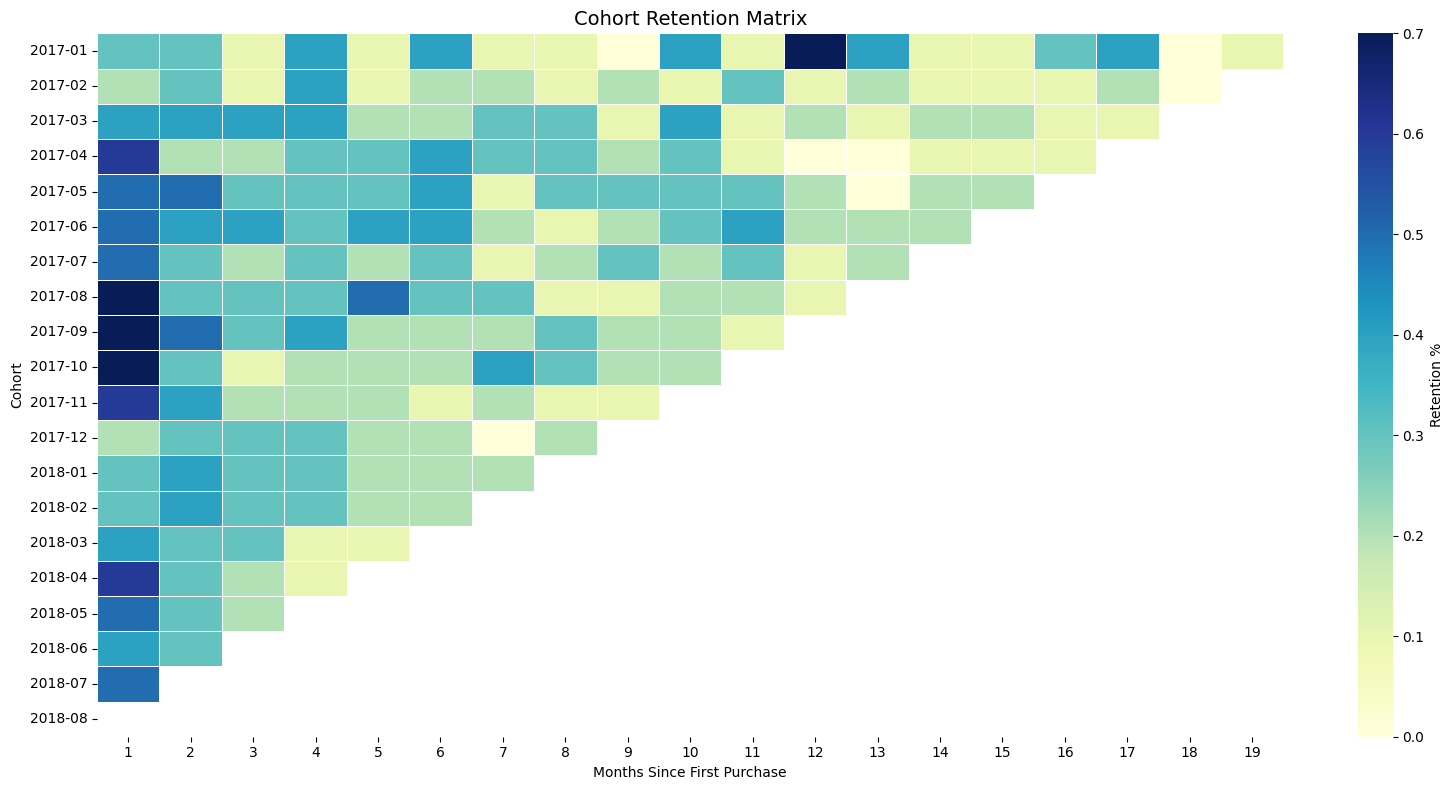

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# убираем M0
heatmap_data = retention_matrix_filled.drop(columns=0)

# форматируем индекс
heatmap_data.index = heatmap_data.index.strftime('%Y-%m')

plt.figure(figsize=(16, 8))

mask = heatmap_data.isna()

sns.heatmap(
    heatmap_data.round(1),
    mask=mask,
    cmap="YlGnBu",
    annot=False,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Retention %"},
    vmin=0
)

plt.title("Cohort Retention Matrix", fontsize=14)
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort")
plt.tight_layout()
plt.show()

**Среднее удержание по когорте**

In [152]:
# Берём матрицу без индекса 0
retention_no_zero = retention_matrix_filled.drop(columns=0)

# Среднее удержание по строке (по когорте)
avg_retention = (
    retention_no_zero
    .mean(axis=1, skipna=True)
    .reset_index()
    .rename(columns={0: "avg_retention"})
)

avg_retention.columns = ["cohort_month", "avg_retention"]

avg_retention

,cohort_month,avg_retention
0,2017-01-01,0.249578
1,2017-02-01,0.170625
2,2017-03-01,0.235012
3,2017-04-01,0.216090
4,2017-05-01,0.276248
5,2017-06-01,0.296345
6,2017-07-01,0.260374
7,2017-08-01,0.299893
8,2017-09-01,0.313323
9,2017-10-01,0.274954


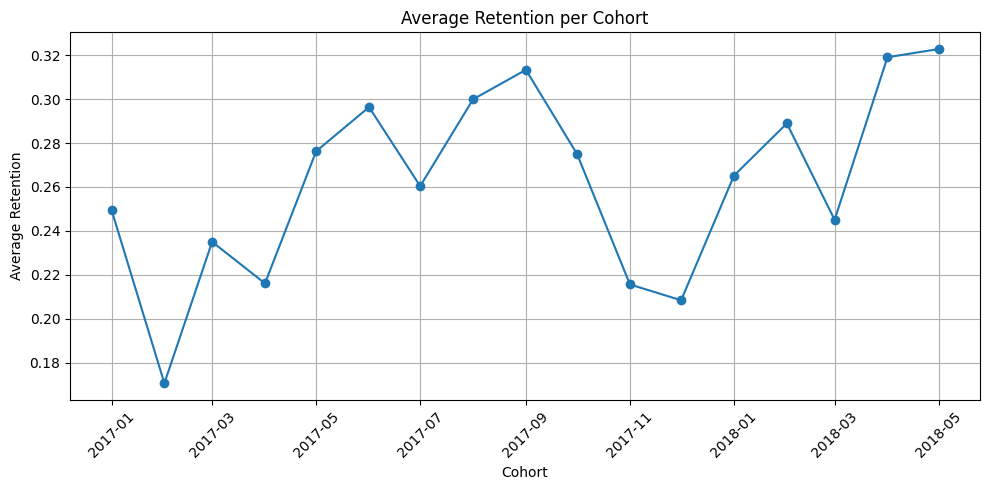

In [153]:
cutoff_date = "2018-05-01"

avg_retention_filtered = avg_retention[
    avg_retention["cohort_month"] <= cutoff_date
]

plt.figure(figsize=(10, 5))

plt.plot(
    avg_retention_filtered["cohort_month"],
    avg_retention_filtered["avg_retention"],
    marker="o"
)

plt.title("Average Retention per Cohort")
plt.ylabel("Average Retention")
plt.xlabel("Cohort")
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

## Lifetime (время жизни клиента) из матрицы удержания

### Идея
Матрица удержания показывает долю клиентов когорты, которые совершают покупку в каждом месяце после первой покупки.

Если нормировать когорту к одному клиенту, то значение retention_i можно читать как долю “клиент-месяца”, которую в среднем “проживает” клиент в месяце *i*.

---

### Формулы (LaTeX)

Полный lifetime (включая месяц 0):

$$
Lifetime_{\text{full}} = \sum_{i=0}^{T} retention_i
$$

Lifetime после первой покупки (без месяца 0):

$$
Lifetime_{\text{post}} = \sum_{i=1}^{T} retention_i
$$

Где:
- $retention_i$ — удержание в месяце $i$ (доля клиентов когорты, совершивших покупку в этом месяце),
- $T$ — последний наблюдаемый когортный индекс.

---

### Пример расчёта (одна когорта)

| Месяц (cohort_index) | Retention |
|---------------------:|----------:|
| 0                    | 1.00      |
| 1                    | 0.30      |
| 2                    | 0.20      |
| 3                    | 0.10      |

Тогда:

$$
Lifetime_{\text{full}} = 1.00 + 0.30 + 0.20 + 0.10 = 1.60
$$

$$
Lifetime_{\text{post}} = 0.30 + 0.20 + 0.10 = 0.60
$$

---

### Интерпретация
- Lifetime_full — средняя “длина жизни” клиента в месяцах, включая месяц первой покупки.
- Lifetime_post — сколько месяцев в среднем клиент остаётся активным после первой покупки (за счёт повторных покупок).

In [154]:
# Переводим проценты в доли
retention_fraction = retention_matrix / 100

# Lifetime full
lifetime_full = retention_fraction.sum(axis=1, skipna=True)

# Lifetime post (без месяца 0)
lifetime_post = retention_fraction.drop(columns=0).sum(axis=1, skipna=True)

lifetime_df = pd.DataFrame({
    "cohort_month": retention_matrix.index,
    "lifetime_full": lifetime_full,
    "lifetime_post": lifetime_post
}).reset_index(drop=True)

# retention_fraction уже посчитан ранее: retention_matrix / 100

lifetime_full_months = retention_fraction.sum(axis=1, skipna=True)
lifetime_post_months = retention_fraction.drop(columns=0).sum(axis=1, skipna=True)

AVG_DAYS_IN_MONTH = 30.5
lifetime_post_days = lifetime_post_months * AVG_DAYS_IN_MONTH

lifetime_df = pd.DataFrame({
    "cohort_month": retention_matrix.index,
    "lifetime_full_months": lifetime_full_months,
    "lifetime_post_months": lifetime_post_months,
    "lifetime_post_days": lifetime_post_days
}).reset_index(drop=True)

lifetime_df_round = lifetime_df.copy()
lifetime_df_round["lifetime_full_months"] = lifetime_df_round["lifetime_full_months"].round(2)
lifetime_df_round["lifetime_post_months"] = lifetime_df_round["lifetime_post_months"].round(2)
lifetime_df_round["lifetime_post_days"] = lifetime_df_round["lifetime_post_days"].round(1)

lifetime_df_round

,cohort_month,lifetime_full_months,lifetime_post_months,lifetime_post_days
0,2017-01-01,1.05,0.05,1.4
1,2017-02-01,1.03,0.03,0.9
2,2017-03-01,1.04,0.04,1.2
3,2017-04-01,1.03,0.03,1.1
4,2017-05-01,1.04,0.04,1.3
5,2017-06-01,1.04,0.04,1.3
6,2017-07-01,1.03,0.03,1.0
7,2017-08-01,1.04,0.04,1.1
8,2017-09-01,1.03,0.03,1.1
9,2017-10-01,1.03,0.03,0.8


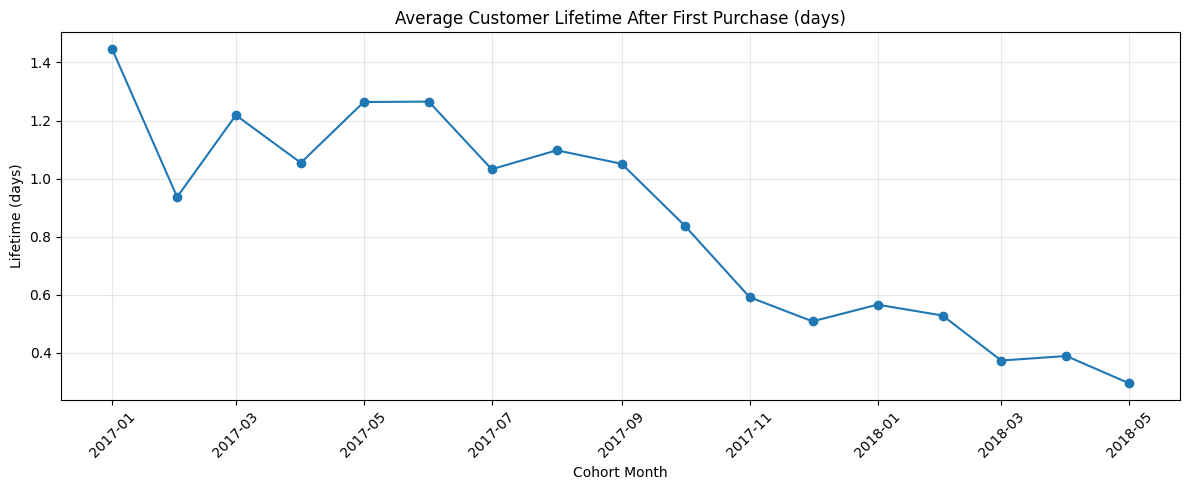

In [155]:
import matplotlib.pyplot as plt

# обрезаем после 2018-05
lifetime_plot_df = lifetime_df[
    lifetime_df["cohort_month"] <= "2018-05-01"
]

plt.figure(figsize=(12, 5))

plt.plot(
    lifetime_plot_df["cohort_month"],
    lifetime_plot_df["lifetime_post_days"],
    marker="o"
)

plt.title("Average Customer Lifetime After First Purchase (days)")
plt.xlabel("Cohort Month")
plt.ylabel("Lifetime (days)")
plt.xticks(rotation=45)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Считаем Cohort Revenue**\
Для этого нужен order_id в orders_window

**Шаг 1. Пересобираем orders_window с order_id**

In [156]:
orders_window = con.execute("""
WITH first_purchase AS (
    SELECT
        c.customer_unique_id,
        MIN(o.order_purchase_timestamp) AS first_purchase_date
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    WHERE o.order_status = 'delivered'
    GROUP BY c.customer_unique_id
),

orders_enriched AS (
    SELECT
        o.order_id,
        c.customer_unique_id,
        DATE_TRUNC('month', o.order_purchase_timestamp) AS order_month,
        DATE_TRUNC('month', fp.first_purchase_date) AS cohort_month,
        DATE_DIFF(
            'month',
            DATE_TRUNC('month', fp.first_purchase_date),
            DATE_TRUNC('month', o.order_purchase_timestamp)
        ) AS cohort_index
    FROM orders o
    JOIN customers c
        ON o.customer_id = c.customer_id
    JOIN first_purchase fp
        ON c.customer_unique_id = fp.customer_unique_id
    WHERE o.order_status = 'delivered'
)

SELECT *
FROM orders_enriched
ORDER BY cohort_month, cohort_index
""").fetchdf()

orders_window.head()

,order_id,customer_unique_id,order_month,cohort_month,cohort_index
0,bfbd0f9bdef84302105ad712db648a6c,830d5b7aaa3b6f1e9ad63703bec97d23,2016-09-01,2016-09-01,0
1,cbbb524a0e1646aa6cf7a3c0bbe517ad,12cc890391e57d7123e004856ff1f137,2016-10-01,2016-10-01,0
2,ac2b7c522d811acba0aa270ed3e112e4,664f7107c351f24b16b68919398730a0,2016-10-01,2016-10-01,0
3,7033745709b7cf1bac7d2533663592de,1dc848c11c2985635c268ff3dea707eb,2016-10-01,2016-10-01,0
4,5cd498954e2b37d71b315166809b4bd7,fb48b86d9a78b53675c121e4ec8981ed,2016-10-01,2016-10-01,0


**Шаг 2. Считаем revenue по заказам**

In [157]:
order_revenue = con.execute("""
SELECT
    order_id,
    SUM(payment_value) AS revenue
FROM payments
GROUP BY order_id
""").fetchdf()

order_revenue.head()

,order_id,revenue
0,42fdf880ba16b47b59251dd489d4441a,128.45
1,298fcdf1f73eb413e4d26d01b25bc1cd,96.12
2,771ee386b001f06208a7419e4fc1bbd7,81.16
3,3d7239c394a212faae122962df514ac7,51.84
4,0573b5e23cbd798006520e1d5b4c6714,51.95


**Шаг 3. Объединяем**

In [158]:
orders_rev = (
    orders_window
    .merge(order_revenue, on="order_id", how="inner")
)

#orders_rev = orders_rev[
 #   (orders_rev["order_month"] >= analysis_start) &
 #   (orders_rev["order_month"] <= analysis_end)
#]

analysis_start = pd.Timestamp("2017-01-01")
analysis_end   = pd.Timestamp("2018-08-01")

orders_rev = orders_rev[
    (orders_rev["order_month"] >= analysis_start) &
    (orders_rev["order_month"] <= analysis_end) &
    (orders_rev["cohort_month"] >= analysis_start) &
    (orders_rev["cohort_month"] <= analysis_end)
].copy()

#orders_rev["cohort_month"].min(), orders_rev["order_month"].min()

orders_rev.head()

,order_id,customer_unique_id,order_month,cohort_month,cohort_index,revenue
277,76c6e866289321a7c93b82b54852dc33,39382392765b6dc74812866ee5ee92a7,2017-01-01,2017-01-01,0,35.95
278,a6cd683d4bd3b9b1f0aa37b27f8116d3,169381f51e4c3e926ef199364aeced22,2017-01-01,2017-01-01,0,609.90
279,f175d67589e059cbbda956f10f0702e6,f7be9bec658c62ab6240b44cd26c0b84,2017-01-01,2017-01-01,0,18.62
280,bd2623f3663c5daa3f89e6b527fd49da,c42ba47d1df4847a1fae69d1407c83d9,2017-01-01,2017-01-01,0,40.86
281,3440f090efa1949bc4e9ebd0b89b2b6c,93027a697145bb67a134f56e9a3f0d9a,2017-01-01,2017-01-01,0,69.45


**Шаг 4. Cohort Revenue (помесячная)**



In [159]:
cohort_revenue_df = (
    orders_rev
    .groupby(["cohort_month", "cohort_index"], as_index=False)["revenue"]
    .sum()
    .sort_values(["cohort_month", "cohort_index"])
)

cohort_revenue_df.head()

,cohort_month,cohort_index,revenue
0,2017-01-01,0,127526.05
1,2017-01-01,1,111.07
2,2017-01-01,2,114.70
3,2017-01-01,3,89.70
4,2017-01-01,4,246.25


**Шаг 5. Делаем матрицу revenue (pivot)**

In [160]:
revenue_matrix = cohort_revenue_df.pivot(
    index="cohort_month",
    columns="cohort_index",
    values="revenue"
)

# revenue_matrix уже после pivot
max_idx = int(orders_rev["cohort_index"].max())
full_cols = range(0, max_idx + 1)

revenue_matrix = revenue_matrix.reindex(columns=full_cols)

# 1) внутри треугольника: NaN -> 0
revenue_matrix_filled = revenue_matrix.fillna(0)

# 2) срезаем хвост (вне окна) обратно в NaN
for cohort_month in revenue_matrix_filled.index:
    max_possible = max_idx

for cohort_month in revenue_matrix_filled.index:
    max_valid = max_possible_index(cohort_month)     # <-- та же функция, что была для retention
    revenue_matrix_filled.loc[cohort_month, max_valid+1:] = np.nan

revenue_matrix_filled

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort_month,,,,,,,,,,,,,,,,,,,,
2017-01-01,127526.05,111.07,114.70,89.70,246.25,69.33,448.43,105.17,47.05,0.00,427.05,66.60,552.45,351.65,93.70,104.61,219.35,354.43,0.0,50.93
2017-02-01,271187.58,481.68,570.63,118.73,1151.96,74.21,688.92,274.30,464.61,385.35,343.22,454.39,279.24,397.11,181.66,136.79,291.68,369.65,0.0,NaN
2017-03-01,413773.01,1623.63,1737.12,1836.10,1213.97,1433.39,689.18,887.42,1385.61,237.96,725.93,380.30,907.29,238.58,687.41,717.55,203.88,308.56,NaN,NaN
2017-04-01,388556.92,2937.00,940.40,758.21,1158.30,1208.34,2083.83,1096.55,963.99,499.82,694.78,343.17,175.13,271.64,301.83,272.63,962.61,NaN,NaN,NaN
2017-05-01,562027.63,1931.57,2857.55,1835.74,1219.04,1638.47,3002.26,608.02,1623.52,1353.84,1459.06,1438.36,1056.81,62.33,665.10,746.42,NaN,NaN,NaN,NaN
2017-06-01,484296.24,2162.00,2142.03,1484.87,1434.43,1595.53,1601.41,822.86,346.26,497.30,2232.08,2063.00,513.44,1047.89,2454.39,NaN,NaN,NaN,NaN,NaN
2017-07-01,558533.43,3070.50,1307.59,1156.32,1281.37,1865.65,2553.19,250.36,413.96,2071.11,1163.02,1264.85,1409.38,876.49,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-01,635566.56,5056.77,2229.03,1014.62,1755.13,2883.84,1864.71,1949.83,1800.03,1204.91,1460.16,1825.60,595.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09-01,689826.07,3659.34,3182.57,1661.37,3226.19,2055.95,1067.34,965.33,1168.15,695.80,1195.16,326.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


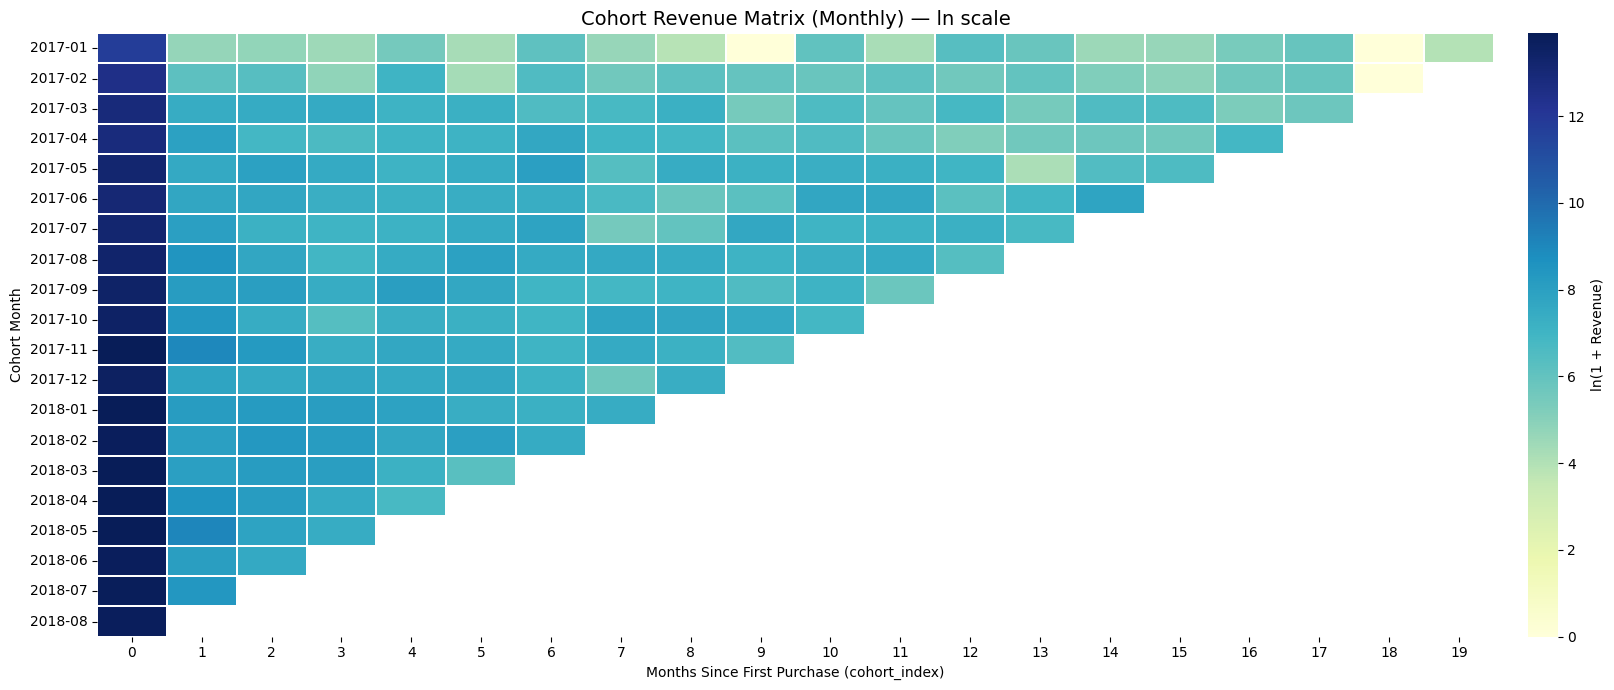

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 0) Подготовка матрицы
# =========================

rev = revenue_matrix_filled.copy()

# если cohort_month / index вдруг не строка даты приведем индекс к нужному виду
if isinstance(rev.index, (pd.DatetimeIndex, pd.PeriodIndex)):
    rev.index = pd.to_datetime(rev.index).strftime("%Y-%m")
else:
    # на случай если там уже строки, но с временем:
    try:
        rev.index = pd.to_datetime(rev.index).strftime("%Y-%m")
    except Exception:
        pass

# Убедимся что колонки cohort_index числа и отсортированы
try:
    rev.columns = rev.columns.astype(int)
    rev = rev.reindex(sorted(rev.columns), axis=1)
except Exception:
    pass

# =========================
# 1) Общая heatmap (ln scale)
# =========================
# Логарифмируем ТОЛЬКО для визуализации
rev_ln = np.log1p(rev)

# Чтобы экстремумы не сжигали палитру:
# vmax берем как 99-й перцентиль (игнорируя NaN)
vmin_all = np.nanmin(rev_ln.values)
vmax_all = np.nanpercentile(rev_ln.values, 99)

plt.figure(figsize=(18, 7))
ax = sns.heatmap(
    rev_ln,
    cmap="YlGnBu",
    linewidths=0.25,
    linecolor="white",
    vmin=vmin_all,
    vmax=vmax_all,
    cbar_kws={"label": "ln(1 + Revenue)", "pad": 0.02}
)

ax.set_title("Cohort Revenue Matrix (Monthly) — ln scale", fontsize=14)
ax.set_xlabel("Months Since First Purchase (cohort_index)")
ax.set_ylabel("Cohort Month")

plt.tight_layout()
plt.show()

/tmp/ipython-input-3696035427.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


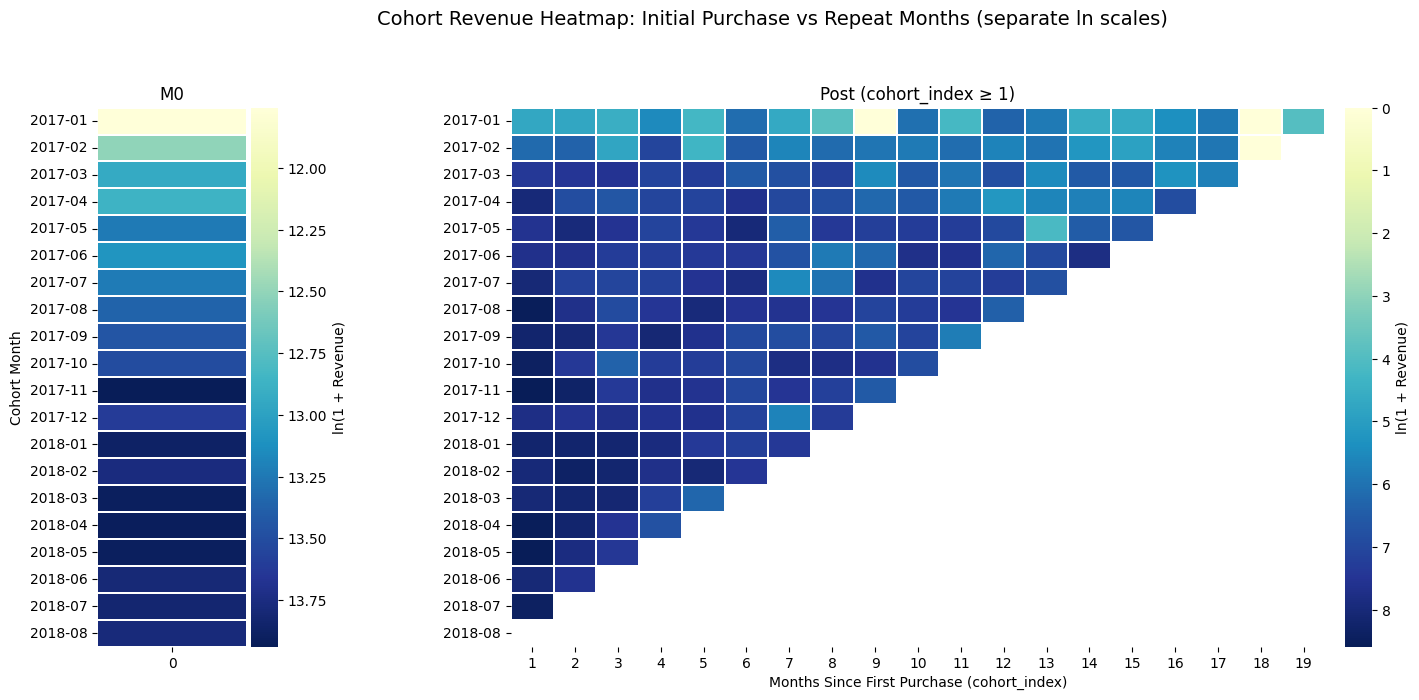

In [162]:
# =========================
# 2) Split-версия: M0 отдельно + Post (>=1) отдельно
# =========================

# M0 (index 0)
m0 = rev[[0]].copy() if 0 in rev.columns else rev.iloc[:, [0]].copy()

# Post (index >= 1)
post_cols = [c for c in rev.columns if isinstance(c, (int, np.integer)) and c >= 1]
post = rev[post_cols].copy()

# ln scale (только визуализация)
m0_ln = np.log1p(m0)
post_ln = np.log1p(post)

# vmax отдельно для M0 и отдельно для Post (снова 99-й перцентиль)
m0_vmin = np.nanmin(m0_ln.values)
m0_vmax = np.nanpercentile(m0_ln.values, 99)

post_vmin = np.nanmin(post_ln.values)
post_vmax = np.nanpercentile(post_ln.values, 99)

fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 6.5], wspace=0.40)  # <-- увеличили расстояние

# --- M0 ---
ax0 = fig.add_subplot(gs[0, 0])
sns.heatmap(
    m0_ln,
    ax=ax0,
    cmap="YlGnBu",
    linewidths=0.25,
    linecolor="white",
    vmin=m0_vmin,
    vmax=m0_vmax,
    cbar=True,
    cbar_kws={"label": "ln(1 + Revenue)", "pad": 0.02}
)
ax0.set_title("M0", fontsize=12)
ax0.set_xlabel("")             # убираем лишнее
ax0.set_ylabel("Cohort Month")
ax0.set_xticklabels(["0"], rotation=0)

cbar = ax0.collections[0].colorbar
cbar.ax.invert_yaxis()

# --- Post ---
ax1 = fig.add_subplot(gs[0, 1])
sns.heatmap(
    post_ln,
    ax=ax1,
    cmap="YlGnBu",
    linewidths=0.25,
    linecolor="white",
    vmin=post_vmin,
    vmax=post_vmax,
    cbar=True,
    cbar_kws={"label": "ln(1 + Revenue)", "pad": 0.02}
)
ax1.set_title("Post (cohort_index ≥ 1)", fontsize=12)
ax1.set_xlabel("Months Since First Purchase (cohort_index)")
ax1.set_ylabel("")  # чтобы не дублировать слева

fig.suptitle(
    "Cohort Revenue Heatmap: Initial Purchase vs Repeat Months (separate ln scales)",
    fontsize=14,
    y=1.02
)

cbar1 = ax1.collections[0].colorbar
cbar1.ax.invert_yaxis()   # <-- переворачиваем только шкалу

plt.tight_layout()
plt.show()

## Выводы по Cohort Revenue Heatmap

### Практически полная монетизация в месяц первой покупки (M0)

Разница между M0 и последующими месяцами составляет 4-6 единиц натурального логарифма. Это соответствует падению примерно в 100 раз в абсолютных значениях.

---

### Повторная выручка стабильна

После первого месяца:

- значения находятся в узком диапазоне,
- выраженных волн, циклов или системных всплесков не наблюдается,
- структура повторной монетизации визуально ровная.

Основной разрыв между M0 и всеми последующими месяцами.

---

### M0 постепенно растёт у более поздних когорт

Более поздние когорты демонстрируют более высокую выручку в месяц первой покупки. Это согласуется с ростом количества заказов. Возможен рост среднего чека, но это требует отдельной проверки.

---

### Повторная монетизация не компенсирует падение после M0

Даже с учётом логарифмической шкалы видно, что вклад повторных месяцев
несопоставим с выручкой в месяц первой покупки. Бизнес-модель явно ориентирована на первичную продажу.

---

## Итог

- Основной драйвер выручки новые клиенты.
- Повторные продажи существуют, но масштаб их существенно ниже.
- Потенциал роста в увеличении retention и LTV.

**Cumulative revenue по когортам**

In [163]:
# cumulative revenue по месяцам
cumulative_revenue = revenue_matrix_filled.copy()

cumulative_revenue = cumulative_revenue.cumsum(axis=1)

cumulative_revenue.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort_month,,,,,,,,,,,,,,,,,,,,
2017-01-01,127526.05,127637.12,127751.82,127841.52,128087.77,128157.10,128605.53,128710.70,128757.75,128757.75,129184.80,129251.40,129803.85,130155.50,130249.20,130353.81,130573.16,130927.59,130927.59,130978.52
2017-02-01,271187.58,271669.26,272239.89,272358.62,273510.58,273584.79,274273.71,274548.01,275012.62,275397.97,275741.19,276195.58,276474.82,276871.93,277053.59,277190.38,277482.06,277851.71,277851.71,NaN
2017-03-01,413773.01,415396.64,417133.76,418969.86,420183.83,421617.22,422306.40,423193.82,424579.43,424817.39,425543.32,425923.62,426830.91,427069.49,427756.90,428474.45,428678.33,428986.89,NaN,NaN
2017-04-01,388556.92,391493.92,392434.32,393192.53,394350.83,395559.17,397643.00,398739.55,399703.54,400203.36,400898.14,401241.31,401416.44,401688.08,401989.91,402262.54,403225.15,NaN,NaN,NaN
2017-05-01,562027.63,563959.20,566816.75,568652.49,569871.53,571510.00,574512.26,575120.28,576743.80,578097.64,579556.70,580995.06,582051.87,582114.20,582779.30,583525.72,NaN,NaN,NaN,NaN


/tmp/ipython-input-320271879.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


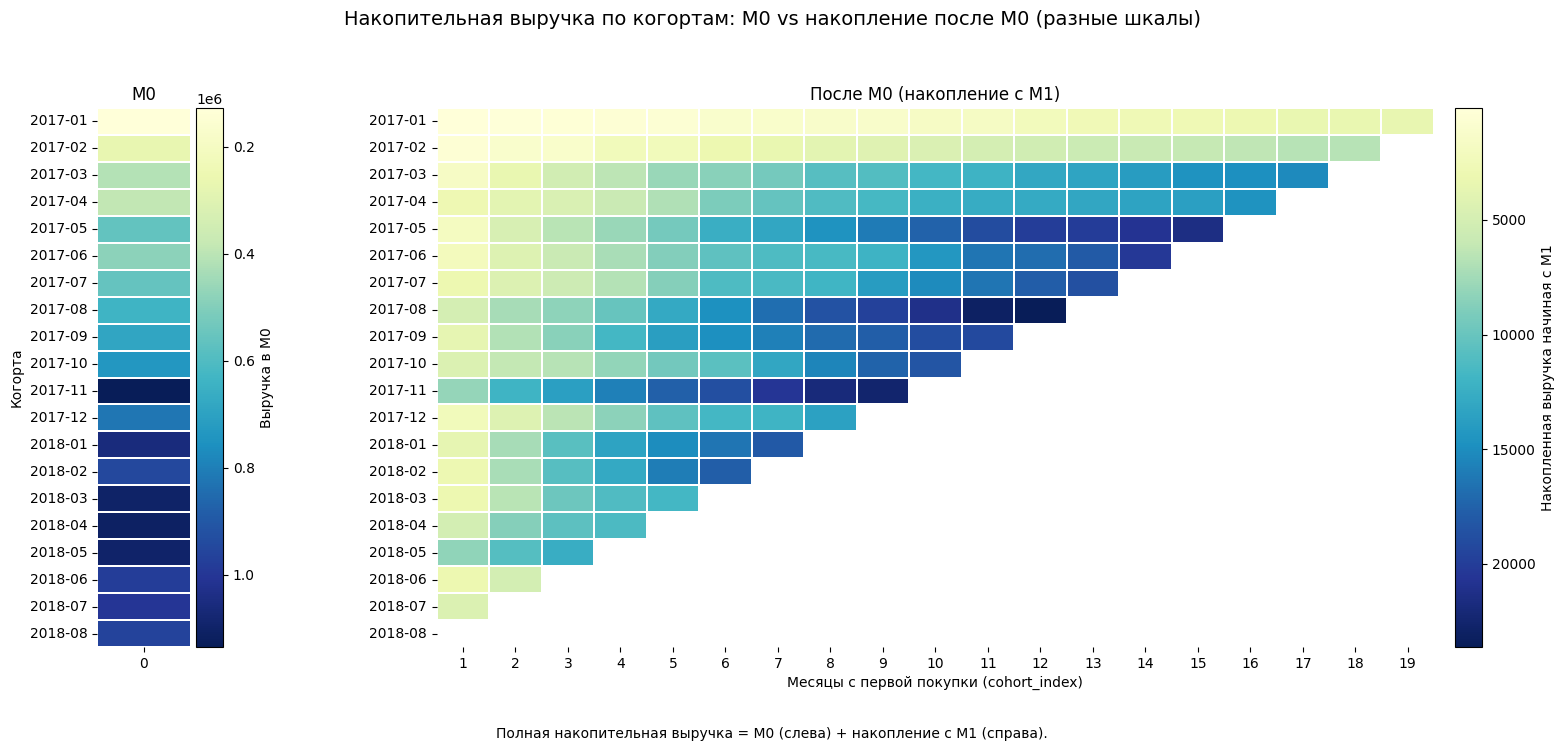

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cum = cumulative_revenue.copy()

# --- Левая часть: M0 ---
m0_abs = cum[[0]].copy()

# --- Правая часть: накопление после M0 ---
post_abs = cum.sub(cum[0], axis=0)
post_abs = post_abs.loc[:, post_abs.columns >= 1]

y_labels = [pd.to_datetime(x).strftime("%Y-%m") for x in m0_abs.index]

plt.close("all")
fig = plt.figure(figsize=(18, 7))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 8], wspace=0.35)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

cmap = "YlGnBu"

# --- M0 ---
hm0 = sns.heatmap(
    m0_abs,
    ax=ax0,
    cmap=cmap,
    linewidths=0.25,
    linecolor="white",
    cbar=False
)

ax0.set_title("M0", fontsize=12)
ax0.set_xlabel("")
ax0.set_ylabel("Когорта")
ax0.set_yticklabels(y_labels, rotation=0)

cbar0 = ax0.figure.colorbar(hm0.collections[0], ax=ax0, fraction=0.25, pad=0.04)
cbar0.set_label("Выручка в M0", rotation=90)
cbar0.ax.invert_yaxis()

# --- После M0 ---
hm1 = sns.heatmap(
    post_abs,
    ax=ax1,
    cmap=cmap,
    linewidths=0.25,
    linecolor="white",
    cbar=False
)

ax1.set_title("После M0 (накопление с M1)", fontsize=12)
ax1.set_xlabel("Месяцы с первой покупки (cohort_index)")
ax1.set_ylabel("")
ax1.set_yticklabels(y_labels, rotation=0)

cbar1 = ax1.figure.colorbar(hm1.collections[0], ax=ax1, fraction=0.035, pad=0.02)
cbar1.set_label("Накопленная выручка начиная с M1", rotation=90)
cbar1.ax.invert_yaxis()

fig.suptitle(
    "Накопительная выручка по когортам: M0 vs накопление после M0 (разные шкалы)",
    fontsize=14,
    y=1.02
)

fig.text(
    0.5,
    -0.02,
    "Полная накопительная выручка = M0 (слева) + накопление с M1 (справа).",
    ha="center",
    fontsize=10
)

plt.tight_layout()
plt.show()

**LIFETIME VALUE**

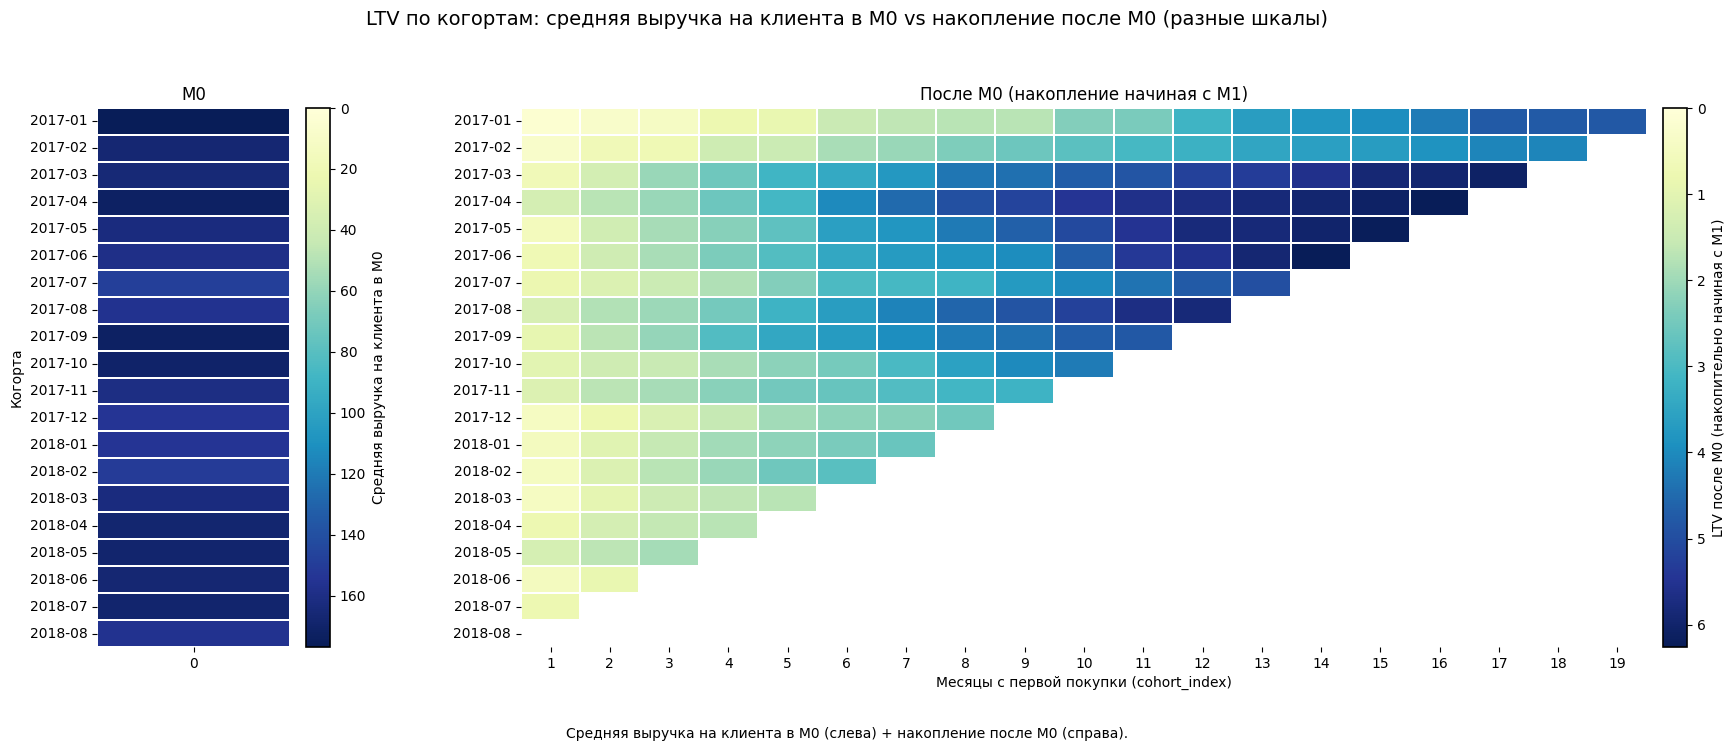

In [165]:
cum = cumulative_revenue.copy()

cum.index = pd.to_datetime(cum.index)

cs = cohort_size.copy()
cs["cohort_month"] = pd.to_datetime(cs["cohort_month"])
cs = cs.set_index("cohort_month")["cohort_size"]

# пересечение когорт (на всякий)
common_idx = cum.index.intersection(cs.index)
cum = cum.loc[common_idx].sort_index()
cs = cs.loc[cum.index]

y_labels = [d.strftime("%Y-%m") for d in cum.index]

# =========================================================
# 1) LTV: M0 и накопление после M0 (с M1)
# =========================================================
rev_m0 = cum.iloc[:, 0]  # cumulative at cohort_index=0
ltv_m0 = (rev_m0 / cs).to_frame(name=0)

post_cols = [c for c in cum.columns if c >= 1]
cum_post = cum[post_cols].sub(rev_m0, axis=0)      # (Cum - M0) по строкам
ltv_post = cum_post.div(cs, axis=0)                # делим на размер когорты

# =========================================================
# 3) Heatmap раздельная: M0 vs После M0 (разные шкалы)
#    + colorbar по высоте 1-в-1 с каждой осью
# =========================================================
plt.close("all")
fig = plt.figure(figsize=(20, 7))

gs = fig.add_gridspec(1, 2, width_ratios=[1.2, 7], wspace=0.35)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

# шкалы (клип 99% чтобы выбросы не ломали градиент)
m0_vals = ltv_m0.to_numpy().ravel()
m0_vals = m0_vals[~np.isnan(m0_vals)]
m0_vmin, m0_vmax = 0, (np.quantile(m0_vals, 0.99) if len(m0_vals) else 1)

post_vals = ltv_post.to_numpy().ravel()
post_vals = post_vals[~np.isnan(post_vals)]
post_vmin, post_vmax = 0, (np.quantile(post_vals, 0.99) if len(post_vals) else 1)

# --- M0 ---
hm0 = sns.heatmap(
    ltv_m0,
    ax=ax0,
    cmap="YlGnBu",
    linewidths=0.25,
    linecolor="white",
    vmin=m0_vmin,
    vmax=m0_vmax,
    cbar=False
)
ax0.set_title("M0", fontsize=12)
ax0.set_xlabel("")
ax0.set_ylabel("Когорта")
ax0.set_yticklabels(y_labels, rotation=0)

# ручной cax ровно по высоте ax0
pos0 = ax0.get_position()
cax0 = fig.add_axes([pos0.x1 + 0.008, pos0.y0, 0.012, pos0.height])  # [x, y, w, h]
cbar0 = fig.colorbar(hm0.collections[0], cax=cax0)
cbar0.set_label("Средняя выручка на клиента в M0", rotation=90)
cbar0.ax.invert_yaxis()                 # переворачиваем ТОЛЬКО шкалу
cbar0.outline.set_visible(True)
cbar0.outline.set_linewidth(1.2)

# --- После M0 (накопление с M1) ---
hm1 = sns.heatmap(
    ltv_post,
    ax=ax1,
    cmap="YlGnBu",
    linewidths=0.25,
    linecolor="white",
    vmin=post_vmin,
    vmax=post_vmax,
    cbar=False
)
ax1.set_title("После M0 (накопление начиная с M1)", fontsize=12)
ax1.set_xlabel("Месяцы с первой покупки (cohort_index)")
ax1.set_ylabel("")
ax1.set_yticklabels(y_labels, rotation=0)

# ручной cax ровно по высоте ax1
pos1 = ax1.get_position()
cax1 = fig.add_axes([pos1.x1 + 0.008, pos1.y0, 0.012, pos1.height])  # [x, y, w, h]
cbar1 = fig.colorbar(hm1.collections[0], cax=cax1)
cbar1.set_label("LTV после M0 (накопительно начиная с M1)", rotation=90)
cbar1.ax.invert_yaxis()                 # переворачиваем ТОЛЬКО шкалу
cbar1.outline.set_visible(True)
cbar1.outline.set_linewidth(1.2)

fig.suptitle("LTV по когортам: средняя выручка на клиента в M0 vs накопление после M0 (разные шкалы)", fontsize=14, y=1.02)
fig.text(
    0.5, -0.02,
    "Средняя выручка на клиента в M0 (слева) + накопление после M0 (справа).",
    ha="center",
    fontsize=10
)

plt.show()

In [166]:
print("LTV в M0 (Revenue_M0 / cohort_size):")
display(ltv_m0.head())

print("\nLTV после M0 (накопление с M1), первые строки:")
display(ltv_post.head())

LTV в M0 (Revenue_M0 / cohort_size):


,0
cohort_month,
2017-01-01,177.860600
2017-02-01,166.577138
2017-03-01,165.310831
2017-04-01,172.232677
2017-05-01,162.859354



LTV после M0 (накопление с M1), первые строки:


cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
cohort_month,,,,,,,,,,,,,,,,,,,
2017-01-01,0.154909,0.314881,0.439986,0.783431,0.880126,1.505551,1.652232,1.717852,1.717852,2.313459,2.406346,3.176848,3.667294,3.797978,3.943877,4.249805,4.744128,4.744128,4.81516
2017-02-01,0.295872,0.646382,0.719312,1.426904,1.472488,1.895657,2.064146,2.349533,2.586235,2.797058,3.076167,3.247690,3.491615,3.603200,3.687224,3.866388,4.093446,4.093446,NaN
2017-03-01,0.648674,1.342689,2.076249,2.561254,3.133923,3.409265,3.763807,4.317387,4.412457,4.702481,4.854419,5.216900,5.312217,5.586852,5.873528,5.954982,6.078258,NaN,NaN
2017-04-01,1.301862,1.718706,2.054792,2.568223,3.103834,4.027518,4.513577,4.940878,5.162429,5.470399,5.622513,5.700142,5.820550,5.954340,6.075186,6.501875,NaN,NaN,NaN
2017-05-01,0.559713,1.387748,1.919693,2.272935,2.747717,3.617685,3.793871,4.264320,4.656624,5.079418,5.496213,5.802446,5.820507,6.013234,6.229525,NaN,NaN,NaN,NaN


## Выводы накопительная выручка и LTV

### 1. Накопительная выручка

- Основной объём выручки формируется в M0.
- Повторные покупки дают незначительный прирост.
- Первые когорты (2017-01, 2017-02) живут дольше, но суммарно накапливают меньше, чем более поздние. Поздние когорты изначально крупнее, поэтому их суммарная выручка выше.

---

### 2. LTV

- M0 (средняя выручка на клиента в первый месяц) практически одинакова между когортами.
- Это означает, что средний стартовый чек стабилен.
- Рост LTV дальше идёт за счёт повторных покупок, но вклад удержания незначительный.

Главный вывод:
- Доход формируется в M0.
- Различия между когортами определяются их размером, а не изменением среднего чека.
- Удержание присутствует, но слабое.

Практический смысл:
Если продукт допускает повторные покупки, логичнее усиливать удержание, чем пытаться повышать цену. Повторная продажа обычно проще, чем повышение среднего чека, но это зависит от природы продукта.